# AdEase_Time_Series_CaseStudy

# About AdEase

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

Data Dictionary:

There are two csv files given

 *   train_1.csv: In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

The page name contains data in this format:

SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN

having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)

 *   Exog_Campaign_eng: This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

# Table of Contents

* **About AdEase**
* **Feature Engineering and Data Cleaning**
* **Visualizing the data**
* **Visualizing Time Series Data Spread Across Various Languages**
* **Visualizing Decomposition of Series across Various Languages**
* **Plotting ACF AND PACF Plots**
* **Dicky Fuller Test**
* **ARIMA MODEL for ENG Language**
* **Custom GridSearchCV for ARIMA Model**
* **SARIMA MODEL for ENG language**
* **Custom GridSearchCV for SARIMA Model**
* **Facebook prophet for Eng Language**
* **Creating Pipeine for RU language**
* **Creating a Pipeline For Other Languages**
* **Questionnaire:**

In [ ]:
# Analysis
#Importing Required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pages = pd.read_csv('train_1.csv')
Exog_Campaign_eng = pd.read_csv('Exog_Campaign_eng.csv')

In [ ]:
pages.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         NaN  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [ ]:
pages.shape

(145063, 551)

In [ ]:
Exog_Campaign_eng.head()

Exog
0     0
1     0
2     0
3     0
4     0

# Feature Engineering and Data Cleaning

In [ ]:
#Extracting Language from Pages
pages['Language']=pages['Page'].apply(lambda x: x.split('.wiki')[0].split('_')[-1])

In [ ]:
for i in range(0,len(pages)):
    if pages['Language'][i] == 'spider':
        pages['Language'][i] ='commons'
    elif pages['Language'][i] == 'all-agents':
        pages['Language'][i] ='commons'
        

In [ ]:
pages['Language'].unique()

array(['zh', 'fr', 'en', 'commons', 'ru', 'de', 'ja', 'es'], dtype=object)

In [ ]:
#extracting Access Type from Pages
pages['Access_Type']=pages['Page'].apply(lambda x: x.split('.org_')[-1].split('_')[0])

In [ ]:
pages['Access_Type'].unique()

array(['all-access', 'desktop', 'mobile-web'], dtype=object)

In [ ]:
#Extracting Access Origin from Pages
pages['Access_Origin']=pages['Page'].apply(lambda x: x.split('.org_')[-1].split('_')[1])

In [ ]:
pages['Access_Origin'].unique()

array(['spider', 'all-agents'], dtype=object)

In [ ]:
#Extracting Title from pages
pages['Title']=pages['Page'].apply(lambda x: x.split('.')[0].rsplit('_',1)[0])

In [ ]:
pages

Page  2015-07-01  \
0                 2NE1_zh.wikipedia.org_all-access_spider        18.0   
1                  2PM_zh.wikipedia.org_all-access_spider        11.0   
2                   3C_zh.wikipedia.org_all-access_spider         1.0   
3              4minute_zh.wikipedia.org_all-access_spider        35.0   
4       52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN   
...                                                   ...         ...   
145058  Underworld_(serie_de_películas)_es.wikipedia.o...         NaN   
145059  Resident_Evil:_Capítulo_Final_es.wikipedia.org...         NaN   
145060  Enamorándome_de_Ramón_es.wikipedia.org_all-acc...         NaN   
145061  Hasta_el_último_hombre_es.wikipedia.org_all-ac...         NaN   
145062  Francisco_el_matemático_(serie_de_televisión_d...         NaN   

        2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  \
0             11.0         5.0        13.0        14.0         9.0   
1             14.0        15.0        18.0        11.0        13.0   
2              0.0         1.0         1.0         0.0         4.0   
3             13.0        10.0        94.0         4.0        26.0   
4              NaN         NaN         NaN         NaN         NaN   
...            ...         ...         ...         ...         ...   
145058         NaN         NaN         NaN         NaN         NaN   
145059         NaN         NaN         NaN         NaN         NaN   
145060         NaN         NaN         NaN         NaN         NaN   
145061         NaN         NaN         NaN         NaN         NaN   
145062         NaN         NaN         NaN         NaN         NaN   

        2015-07-07  2015-07-08  2015-07-09  ...  2016-12-26  2016-12-27  \
0              9.0        22.0        26.0  ...        14.0        20.0   
1             22.0        11.0        10.0  ...         9.0        30.0   
2              0.0         3.0         4.0  ...         4.0         4.0   
3             14.0         9.0        11.0  ...        16.0        11.0   
4              NaN         NaN         NaN  ...         3.0        11.0   
...            ...         ...         ...  ...         ...         ...   
145058         NaN         NaN         NaN  ...        13.0        12.0   
145059         NaN         NaN         NaN  ...         NaN         NaN   
145060         NaN         NaN         NaN  ...         NaN         NaN   
145061         NaN         NaN         NaN  ...         NaN         NaN   
145062         NaN         NaN         NaN  ...         NaN         NaN   

        2016-12-28  2016-12-29  2016-12-30  2016-12-31  Language  Access_Type  \
0             22.0        19.0        18.0        20.0        zh   all-access   
1             52.0        45.0        26.0        20.0        zh   all-access   
2              6.0         3.0         4.0        17.0        zh   all-access   
3             17.0        19.0        10.0        11.0        zh   all-access   
4             27.0        13.0        36.0        10.0        zh   all-access   
...            ...         ...         ...         ...       ...          ...   
145058        13.0         3.0         5.0        10.0        es   all-access   
145059         NaN         NaN         NaN         NaN        es   all-access   
145060         NaN         NaN         NaN         NaN        es   all-access   
145061         NaN         NaN         NaN         NaN        es   all-access   
145062         NaN         NaN         NaN         NaN        es   all-access   

        Access_Origin                                              Title  
0              spider                                               2NE1  
1              spider                                                2PM  
2              spider                                                 3C  
3              spider                                            4minute  
4              spider                                   52_Hz_I_Love_You  
...        

In [ ]:
pages.drop('Page',axis=1,inplace=True)

In [ ]:
col=list(pages.columns)
col=col[-4:]+col[:-4]
df=pages[col]
df

Language Access_Type Access_Origin  \
0            zh  all-access        spider   
1            zh  all-access        spider   
2            zh  all-access        spider   
3            zh  all-access        spider   
4            zh  all-access        spider   
...         ...         ...           ...   
145058       es  all-access        spider   
145059       es  all-access        spider   
145060       es  all-access        spider   
145061       es  all-access        spider   
145062       es  all-access        spider   

                                                    Title  2015-07-01  \
0                                                    2NE1        18.0   
1                                                     2PM        11.0   
2                                                      3C         1.0   
3                                                 4minute        35.0   
4                                        52_Hz_I_Love_You         NaN   
...                                                   ...         ...   
145058                    Underworld_(serie_de_películas)         NaN   
145059                      Resident_Evil:_Capítulo_Final         NaN   
145060                              Enamorándome_de_Ramón         NaN   
145061                             Hasta_el_último_hombre         NaN   
145062  Francisco_el_matemático_(serie_de_televisión_d...         NaN   

        2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  ...  \
0             11.0         5.0        13.0        14.0         9.0  ...   
1             14.0        15.0        18.0        11.0        13.0  ...   
2              0.0         1.0         1.0         0.0         4.0  ...   
3             13.0        10.0        94.0         4.0        26.0  ...   
4              NaN         NaN         NaN         NaN         NaN  ...   
...            ...         ...         ...         ...         ...  ...   
145058         NaN         NaN         NaN         NaN         NaN  ...   
145059         NaN         NaN         NaN         NaN         NaN  ...   
145060         NaN         NaN         NaN         NaN         NaN  ...   
145061         NaN         NaN         NaN         NaN         NaN  ...   
145062         NaN         NaN         NaN         NaN         NaN  ...   

        2016-12-22  2016-12-23  2016-12-24  2016-12-25  2016-12-26  \
0             32.0        63.0        15.0        26.0        14.0   
1             17.0        42.0        28.0        15.0         9.0   
2              3.0         1.0         1.0         7.0         4.0   
3             32.0        10.0        26.0        27.0        16.0   
4             48.0         9.0        25.0        13.0         3.0   
...            ...         ...         ...         ...         ...   
145058         NaN         NaN         NaN         NaN        13.0   
145059         NaN         NaN         NaN         NaN         NaN   
145060         NaN         NaN         NaN         NaN         NaN   
145061         NaN         NaN         NaN         NaN         NaN   
145062         NaN         NaN         NaN         NaN         NaN   

        2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0             20.0        22.0        19.0        18.0        20.0  
1             30.0        52.0        45.0        26.0        20.0  
2              4.0         6.0         3.0         4.0        17.0  
3             11.0        17.0        19.0        10.0        11.0  
4             11.0        27.0        13.0        36.0        10.0  
...            ...         ...         ...         ...         ...  
145058        12.0        13.0         3.0         5.0        10.0  
145059         NaN         NaN         NaN         NaN         NaN  
145060         NaN         NaN         NaN         NaN         NaN  
145061         NaN         NaN         NaN         NaN         NaN  
145062         NaN         NaN         NaN         NaN         NaN  

[145063 rows x 554

In [ ]:
df1=pd.pivot_table(df, columns =['Language'], aggfunc = np.sum)
df1

Language      commons          de           en          es          fr  \
2015-07-01  1490534.0  13260519.0   84712190.0  15278553.0   8458638.0   
2015-07-02  1561810.0  13079896.0   84438545.0  14601013.0   8512952.0   
2015-07-03  1476261.0  12554042.0   80167728.0  13427632.0   8186030.0   
2015-07-04  1260073.0  11520379.0   83463204.0  12606538.0   8749842.0   
2015-07-05  1396521.0  13392347.0   86198637.0  13710356.0   8590493.0   
...               ...         ...          ...         ...         ...   
2016-12-27  2625377.0  20125264.0  145628734.0  15945353.0  15281470.0   
2016-12-28  3328851.0  19152389.0  141278366.0  16577375.0  13781521.0   
2016-12-29  2629988.0  18447906.0  150557534.0  15647135.0  13399796.0   
2016-12-30  2937872.0  17606030.0  125404585.0  11560095.0  12471074.0   
2016-12-31  2570250.0  16562720.0  123623812.0  11077924.0  11504691.0   

Language            ja          ru         zh  
2015-07-01  11863200.0   9463854.0  4144988.0  
2015-07-02  13620792.0   9627643.0  4151189.0  
2015-07-03  12305383.0   8923463.0  4123659.0  
2015-07-04  15456239.0   8393214.0  4163448.0  
2015-07-05  14827204.0   8938528.0  4441286.0  
...                ...         ...        ...  
2016-12-27  16123301.0  15040168.0  6478442.0  
2016-12-28  16150715.0  14000319.0  6513400.0  
2016-12-29  17682688.0  13478977.0  6042545.0  
2016-12-30  19450687.0  12066750.0  6111203.0  
2016-12-31  24460799.0  13223033.0  6298565.0  

[550 rows x 8 columns]

# Visualizing the data

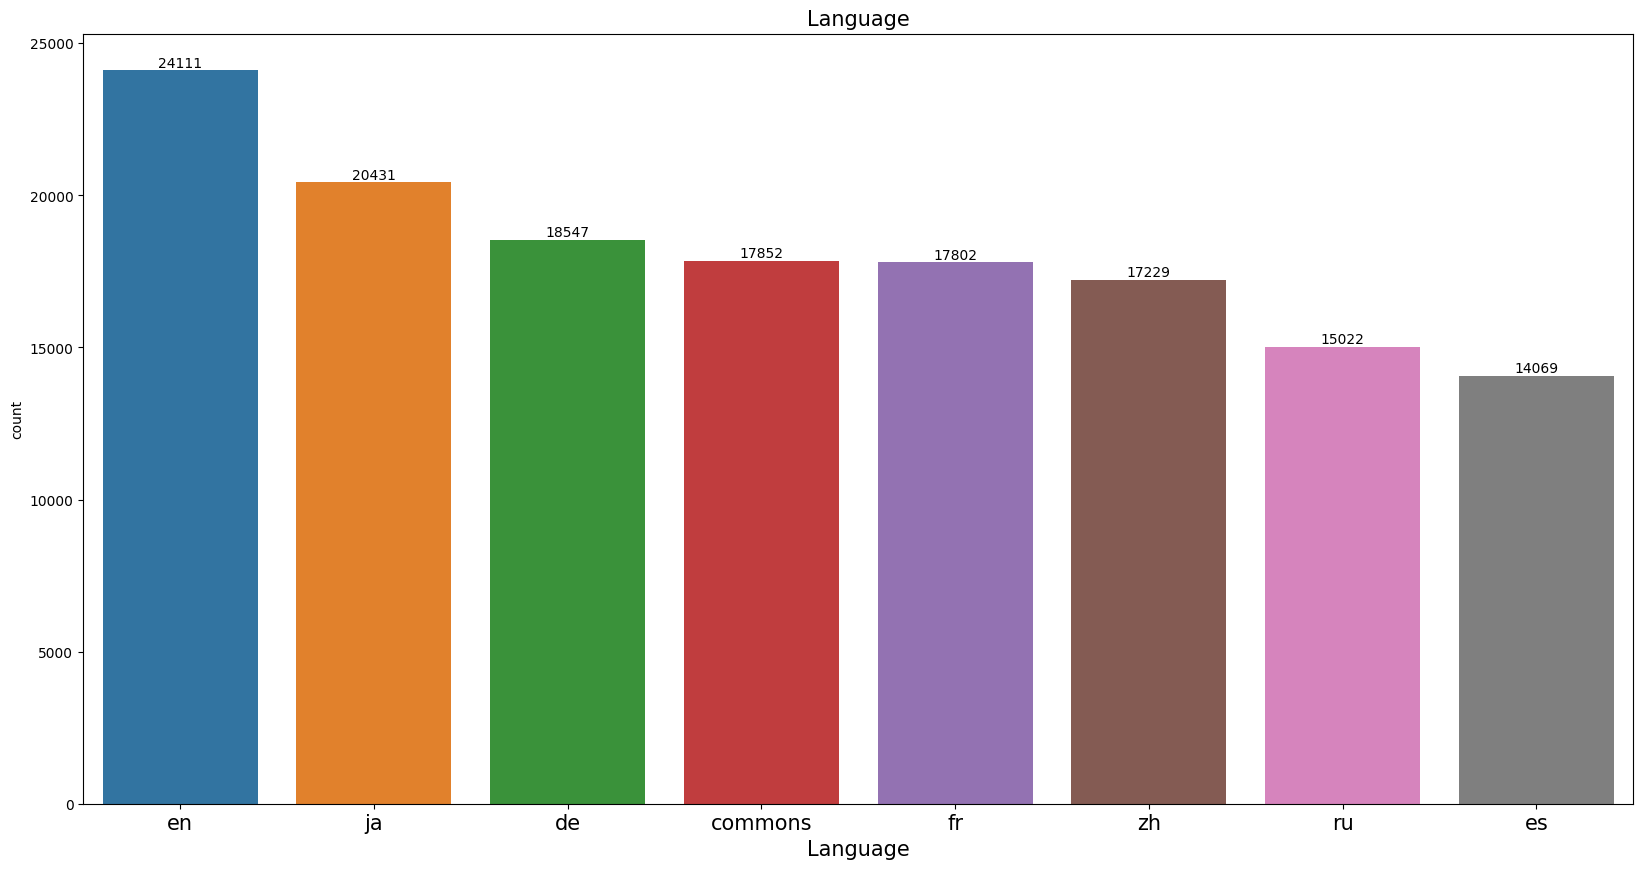

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(data = df, 
              x = 'Language', 
              order = df['Language'].value_counts().index[:], linewidth=0.3)
ax.bar_label(ax.containers[0])
plt.xticks(fontsize=15)
plt.title('Language',fontsize=15)
plt.xlabel('Language',fontsize=15)
plt.show()

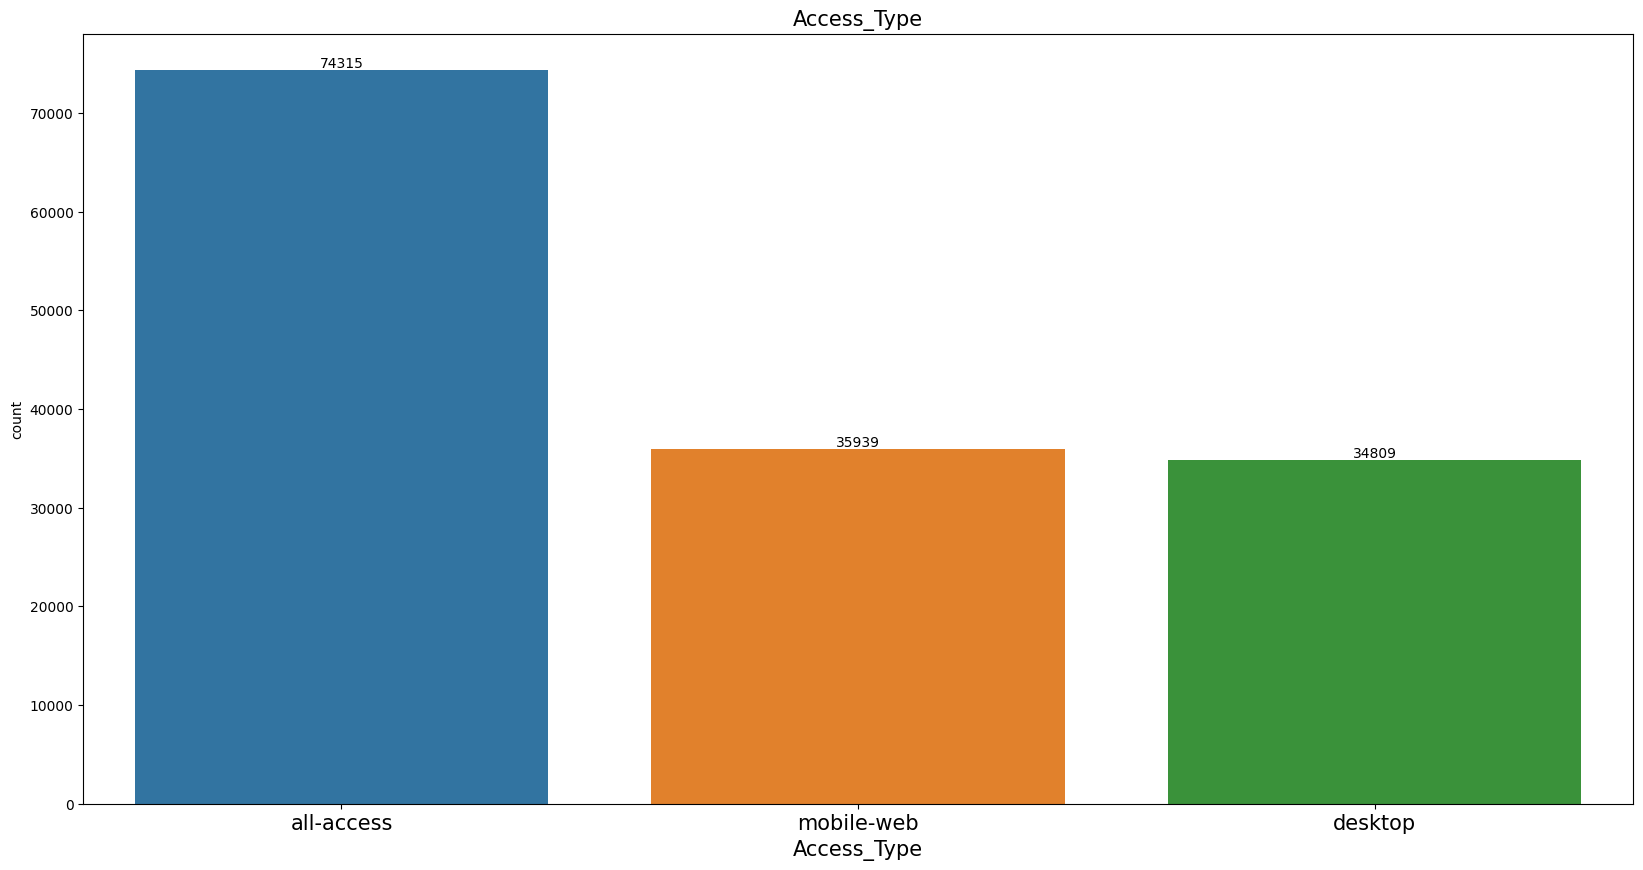

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(data = df, 
              x = 'Access_Type', 
              order = df['Access_Type'].value_counts().index[:], linewidth=0.3)
ax.bar_label(ax.containers[0])
plt.title('Access_Type',fontsize=15)
plt.xlabel('Access_Type',fontsize=15)
plt.xticks(fontsize=15)
plt.show()

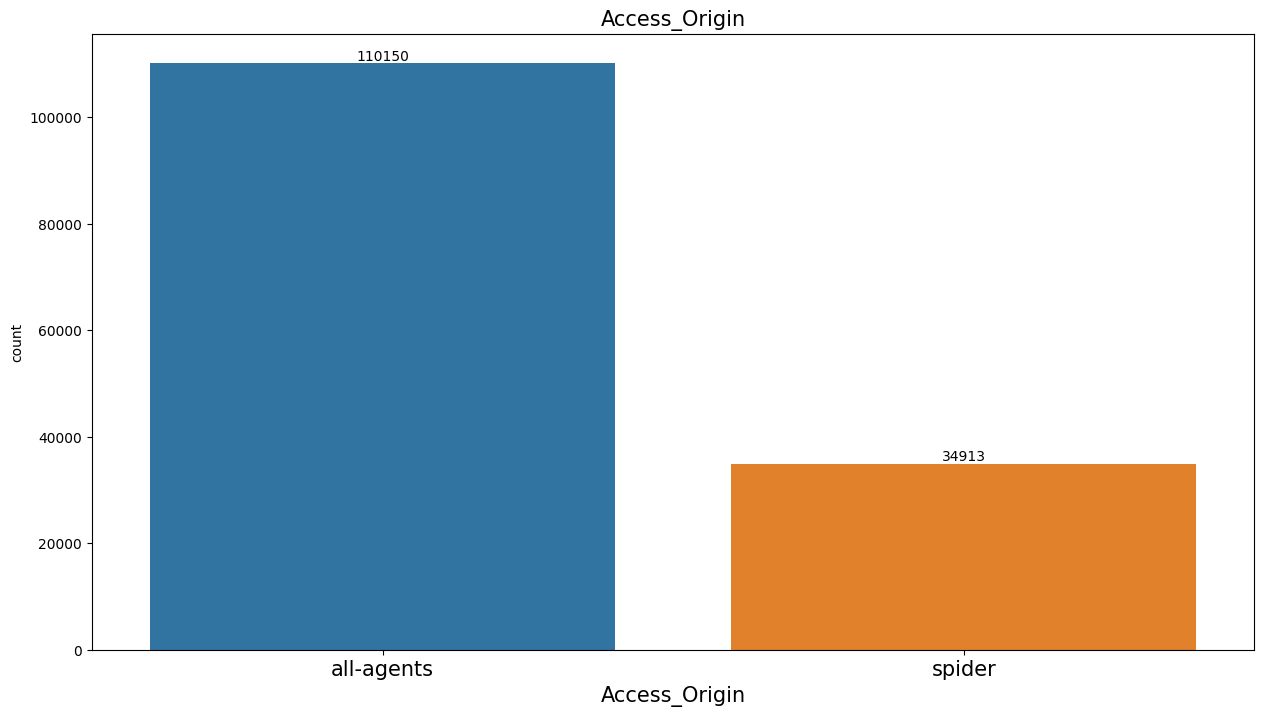

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.countplot(data = df, 
              x = 'Access_Origin', 
              order = df['Access_Origin'].value_counts().index[:], linewidth=0.3)
ax.bar_label(ax.containers[0])
plt.title('Access_Origin',fontsize=15)
plt.xlabel('Access_Origin',fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [ ]:
df1=df1.reset_index()

In [ ]:
df1.rename(columns={'index':'Date'},inplace=True)
df1

Language        Date    commons          de           en          es  \
0         2015-07-01  1490534.0  13260519.0   84712190.0  15278553.0   
1         2015-07-02  1561810.0  13079896.0   84438545.0  14601013.0   
2         2015-07-03  1476261.0  12554042.0   80167728.0  13427632.0   
3         2015-07-04  1260073.0  11520379.0   83463204.0  12606538.0   
4         2015-07-05  1396521.0  13392347.0   86198637.0  13710356.0   
..               ...        ...         ...          ...         ...   
545       2016-12-27  2625377.0  20125264.0  145628734.0  15945353.0   
546       2016-12-28  3328851.0  19152389.0  141278366.0  16577375.0   
547       2016-12-29  2629988.0  18447906.0  150557534.0  15647135.0   
548       2016-12-30  2937872.0  17606030.0  125404585.0  11560095.0   
549       2016-12-31  2570250.0  16562720.0  123623812.0  11077924.0   

Language          fr          ja          ru         zh  
0          8458638.0  11863200.0   9463854.0  4144988.0  
1          8512952.0  13620792.0   9627643.0  4151189.0  
2          8186030.0  12305383.0   8923463.0  4123659.0  
3          8749842.0  15456239.0   8393214.0  4163448.0  
4          8590493.0  14827204.0   8938528.0  4441286.0  
..               ...         ...         ...        ...  
545       15281470.0  16123301.0  15040168.0  6478442.0  
546       13781521.0  16150715.0  14000319.0  6513400.0  
547       13399796.0  17682688.0  13478977.0  6042545.0  
548       12471074.0  19450687.0  12066750.0  6111203.0  
549       11504691.0  24460799.0  13223033.0  6298565.0  

[550 rows x 9 columns]

In [ ]:
df1['Date']= pd.to_datetime(df1['Date'])
df1

Language       Date    commons          de           en          es  \
0        2015-07-01  1490534.0  13260519.0   84712190.0  15278553.0   
1        2015-07-02  1561810.0  13079896.0   84438545.0  14601013.0   
2        2015-07-03  1476261.0  12554042.0   80167728.0  13427632.0   
3        2015-07-04  1260073.0  11520379.0   83463204.0  12606538.0   
4        2015-07-05  1396521.0  13392347.0   86198637.0  13710356.0   
..              ...        ...         ...          ...         ...   
545      2016-12-27  2625377.0  20125264.0  145628734.0  15945353.0   
546      2016-12-28  3328851.0  19152389.0  141278366.0  16577375.0   
547      2016-12-29  2629988.0  18447906.0  150557534.0  15647135.0   
548      2016-12-30  2937872.0  17606030.0  125404585.0  11560095.0   
549      2016-12-31  2570250.0  16562720.0  123623812.0  11077924.0   

Language          fr          ja          ru         zh  
0          8458638.0  11863200.0   9463854.0  4144988.0  
1          8512952.0  13620792.0   9627643.0  4151189.0  
2          8186030.0  12305383.0   8923463.0  4123659.0  
3          8749842.0  15456239.0   8393214.0  4163448.0  
4          8590493.0  14827204.0   8938528.0  4441286.0  
..               ...         ...         ...        ...  
545       15281470.0  16123301.0  15040168.0  6478442.0  
546       13781521.0  16150715.0  14000319.0  6513400.0  
547       13399796.0  17682688.0  13478977.0  6042545.0  
548       12471074.0  19450687.0  12066750.0  6111203.0  
549       11504691.0  24460799.0  13223033.0  6298565.0  

[550 rows x 9 columns]

In [ ]:
## correlation matrix for heat map
df1.corr()

Language   commons        de        en        es        fr        ja  \
Language                                                               
commons   1.000000  0.059039  0.347523  0.228486  0.305359  0.333168   
de        0.059039  1.000000  0.154223  0.300227  0.586279  0.337375   
en        0.347523  0.154223  1.000000  0.101900  0.284675  0.386657   
es        0.228486  0.300227  0.101900  1.000000  0.290677  0.013924   
fr        0.305359  0.586279  0.284675  0.290677  1.000000  0.476908   
ja        0.333168  0.337375  0.386657  0.013924  0.476908  1.000000   
ru        0.046321  0.057187  0.799605  0.005300  0.147278  0.196398   
zh        0.436833  0.392841  0.534174  0.113134  0.588744  0.684289   

Language        ru        zh  
Language                      
commons   0.046321  0.436833  
de        0.057187  0.392841  
en        0.799605  0.534174  
es        0.005300  0.113134  
fr        0.147278  0.588744  
ja        0.196398  0.684289  
ru        1.000000  0.273804  
zh        0.273804  1.000000

<Axes: xlabel='Language', ylabel='Language'>

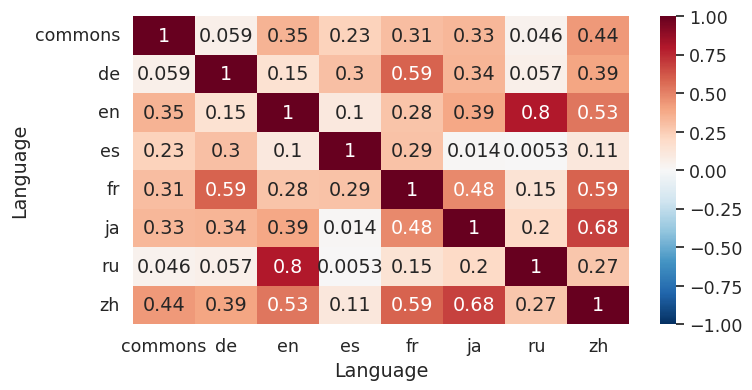

In [ ]:
sns.set(font_scale=1.15)
plt.figure(figsize=(8,4))
sns.heatmap(
    df1.corr(),        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1)

**Observation:**

*  More traffic is seen in English Language Pages
*  Major pages are available in All access type like mobile and Desktop
*  Major pages are originated from all agents.
*  There is higher correlation between english(en) language and russian(ru) language.
*  we can use Exog Variables for russian language also as ru and en languages are correlated.


# Visualizing Time Series Data Spread Across Various Languages

Text(0.5, 0, 'Date')

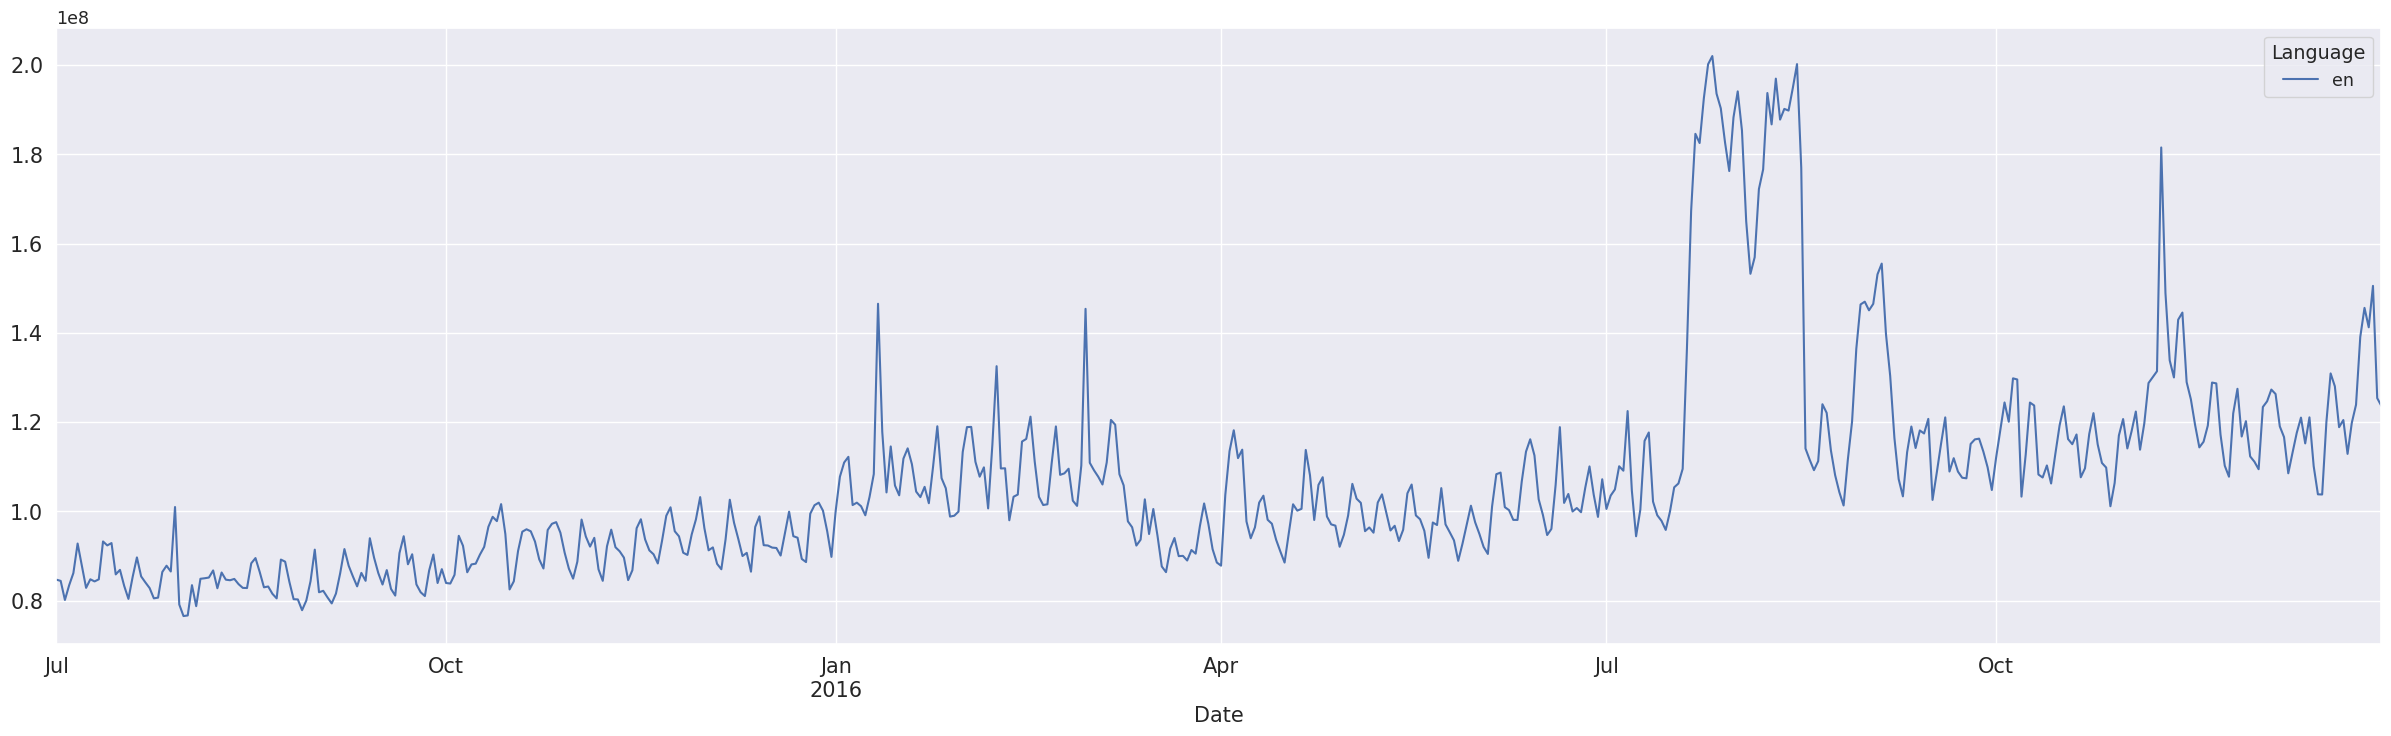

In [ ]:
#Views on En language Pages
df_en=df1[['Date','en']]
df_en.set_index('Date', inplace=True)

df_en.plot(figsize=(30,8),fontsize=15)
plt.xlabel('Date',fontsize=15)

Text(0.5, 0, 'Date')

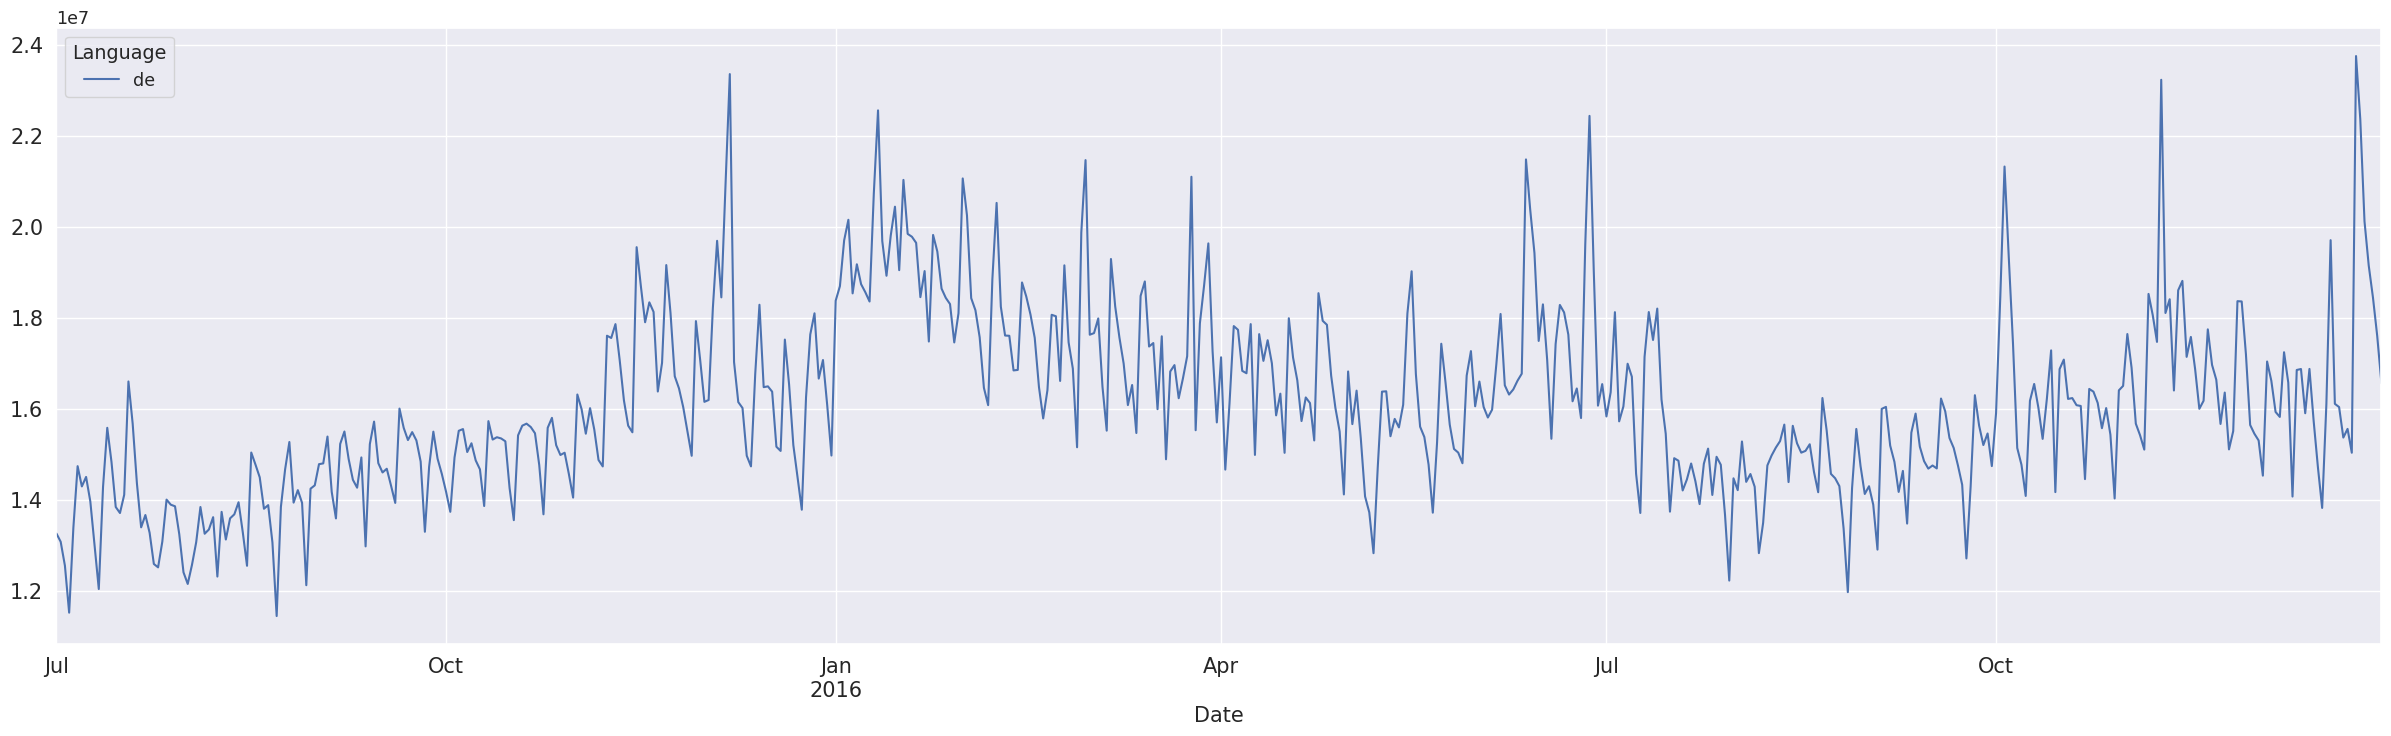

In [ ]:
#Views on De language Pages
df_de=df1[['Date','de']]
df_de.set_index('Date', inplace=True)

df_de.plot(figsize=(30,8),fontsize=15)
plt.xlabel('Date',fontsize=15)

Text(0.5, 0, 'Date')

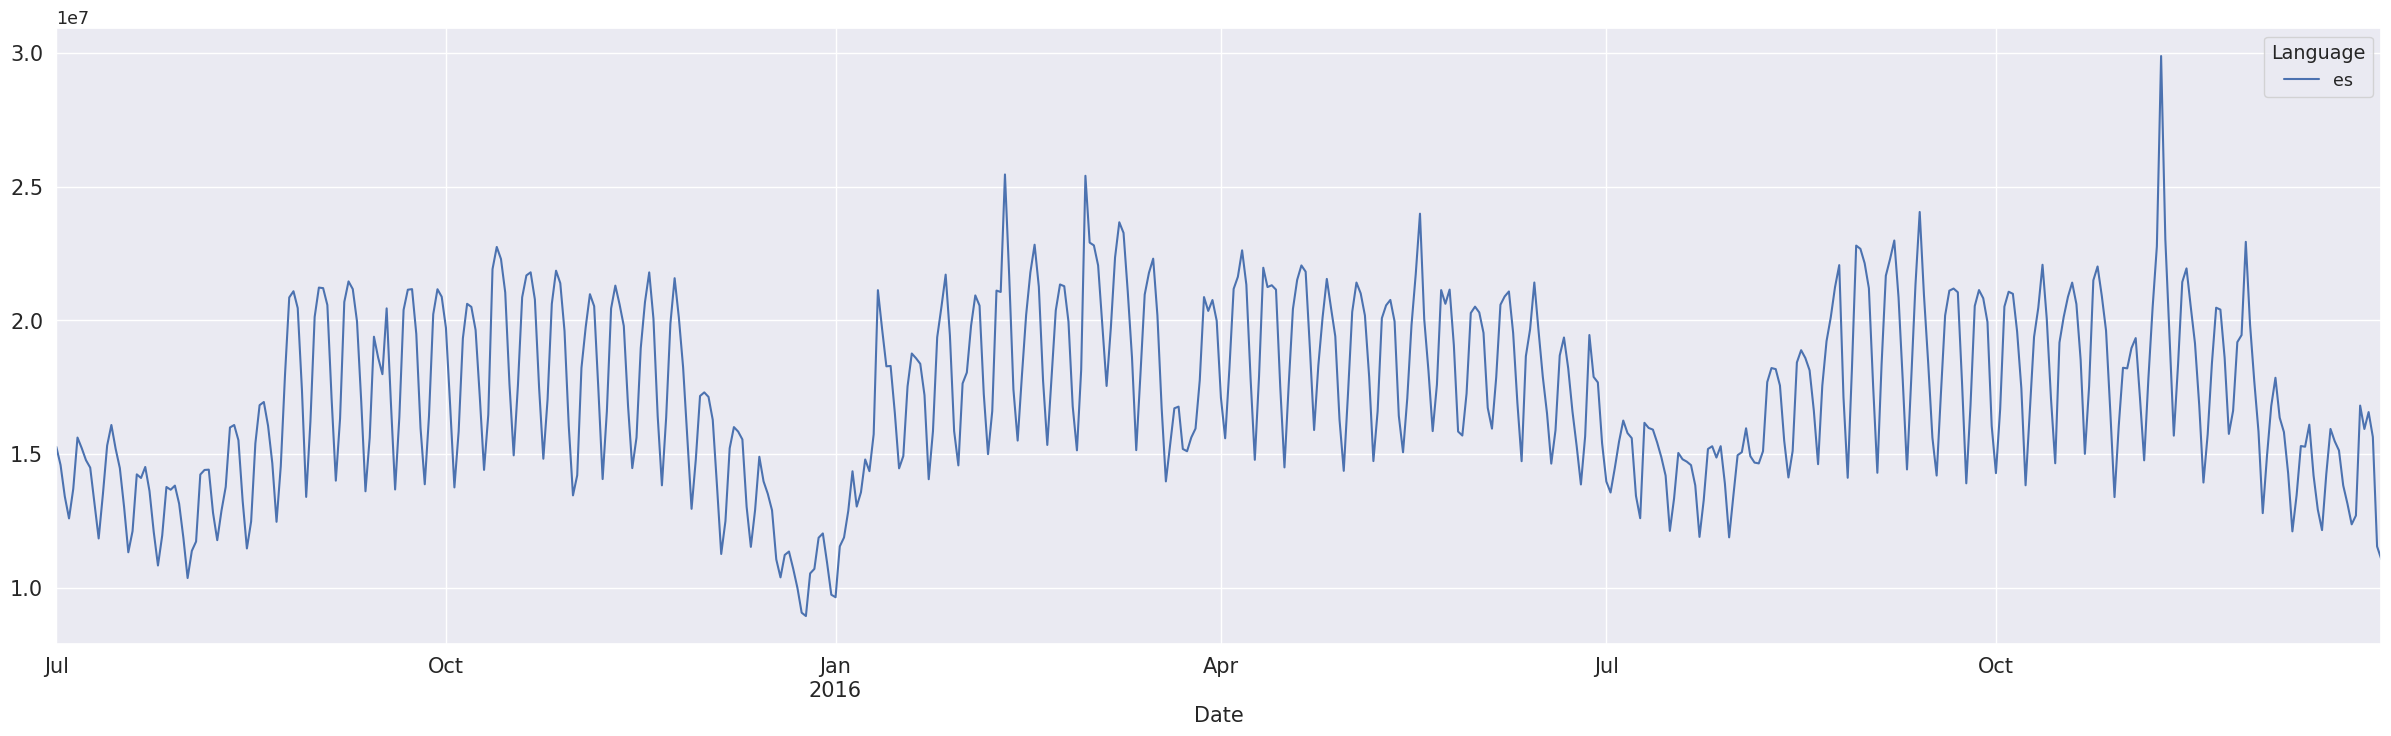

In [ ]:
#Views on Es language Pages
df_es=df1[['Date','es']]
df_es.set_index('Date', inplace=True)

df_es.plot(figsize=(30,8),fontsize=15)
plt.xlabel('Date',fontsize=15)

Text(0.5, 0, 'Date')

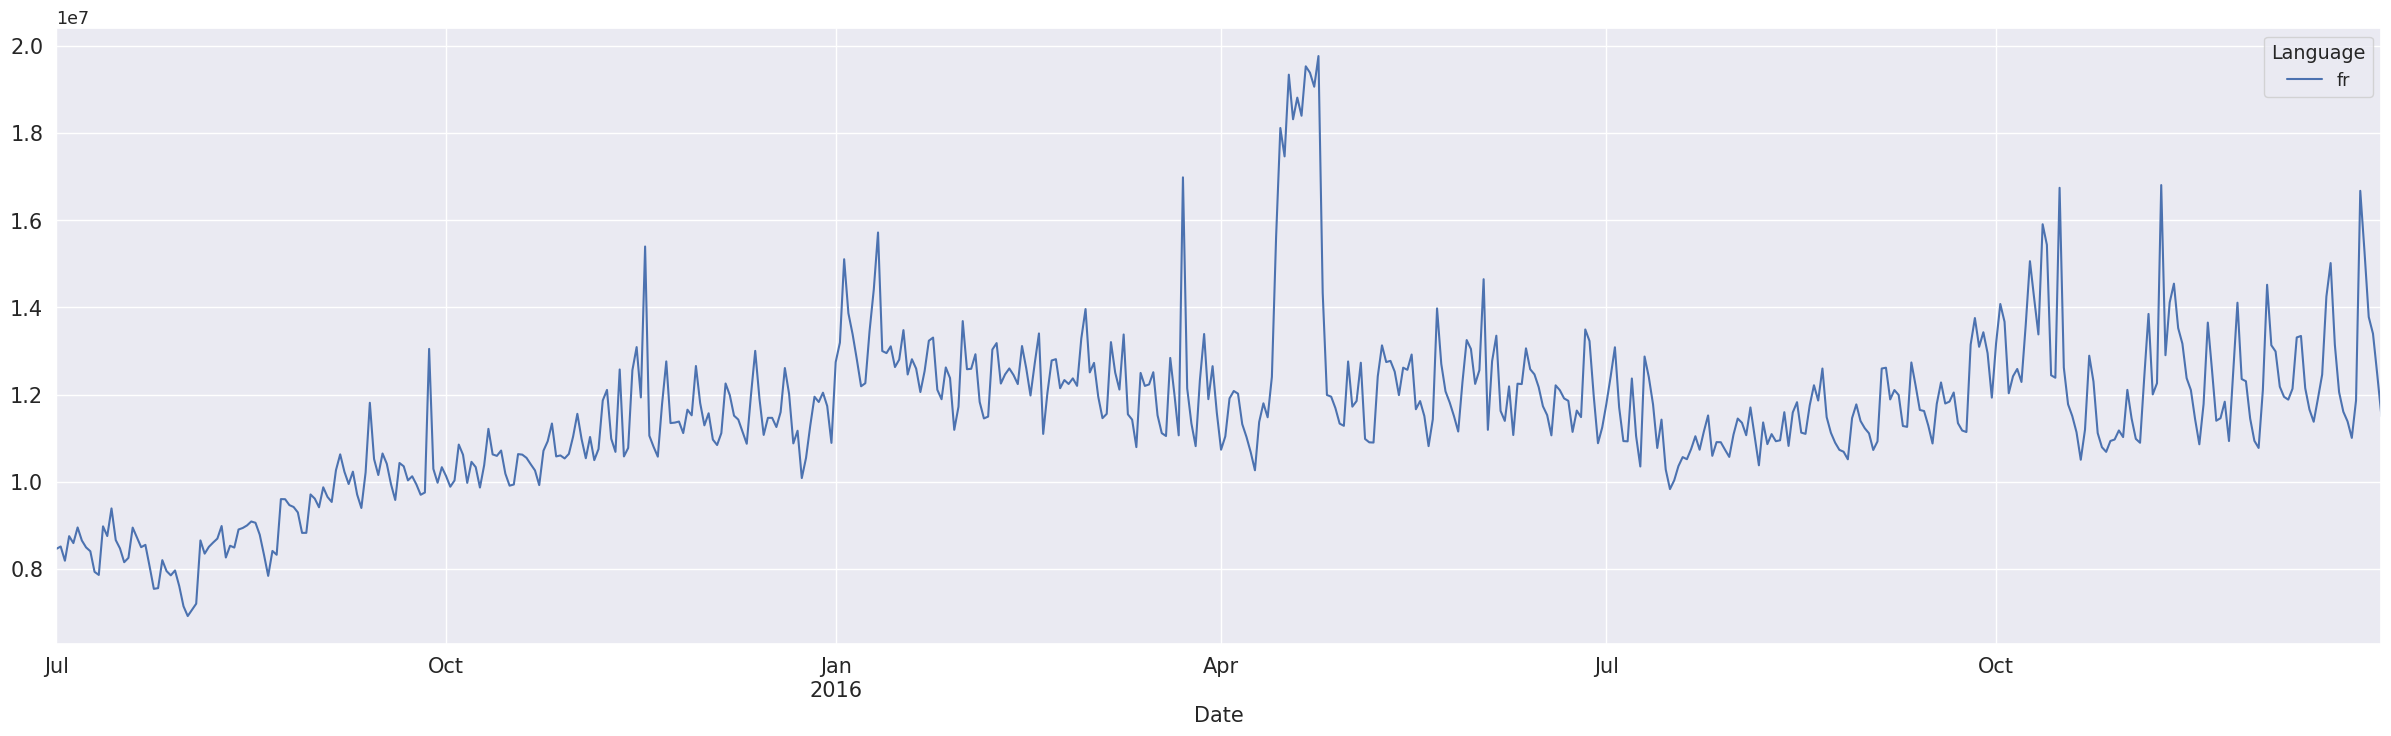

In [ ]:
#Views on Fr language Pages
df_fr=df1[['Date','fr']]
df_fr.set_index('Date', inplace=True)

df_fr.plot(figsize=(30,8),fontsize=15)
plt.xlabel('Date',fontsize=15)

Text(0.5, 0, 'Date')

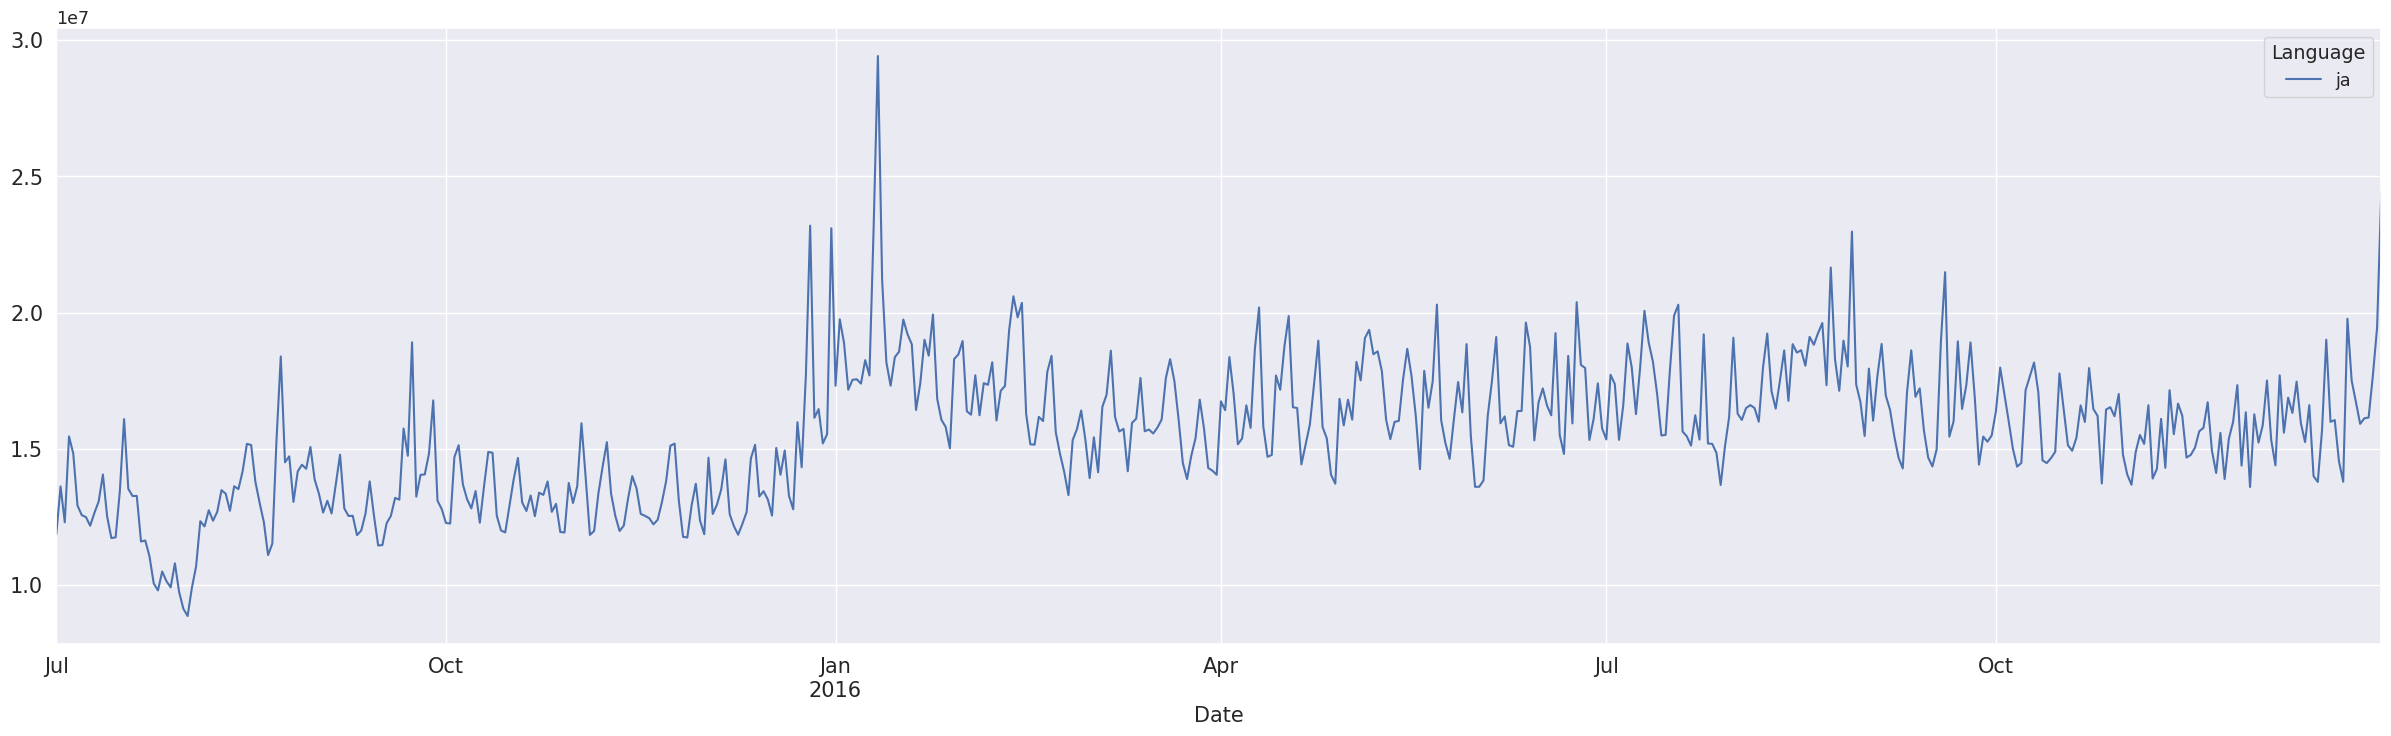

In [ ]:
#Views on Ja language Pages
df_ja=df1[['Date','ja']]
df_ja.set_index('Date', inplace=True)

df_ja.plot(figsize=(30,8),fontsize=15)
plt.xlabel('Date',fontsize=15)

Text(0.5, 0, 'Date')

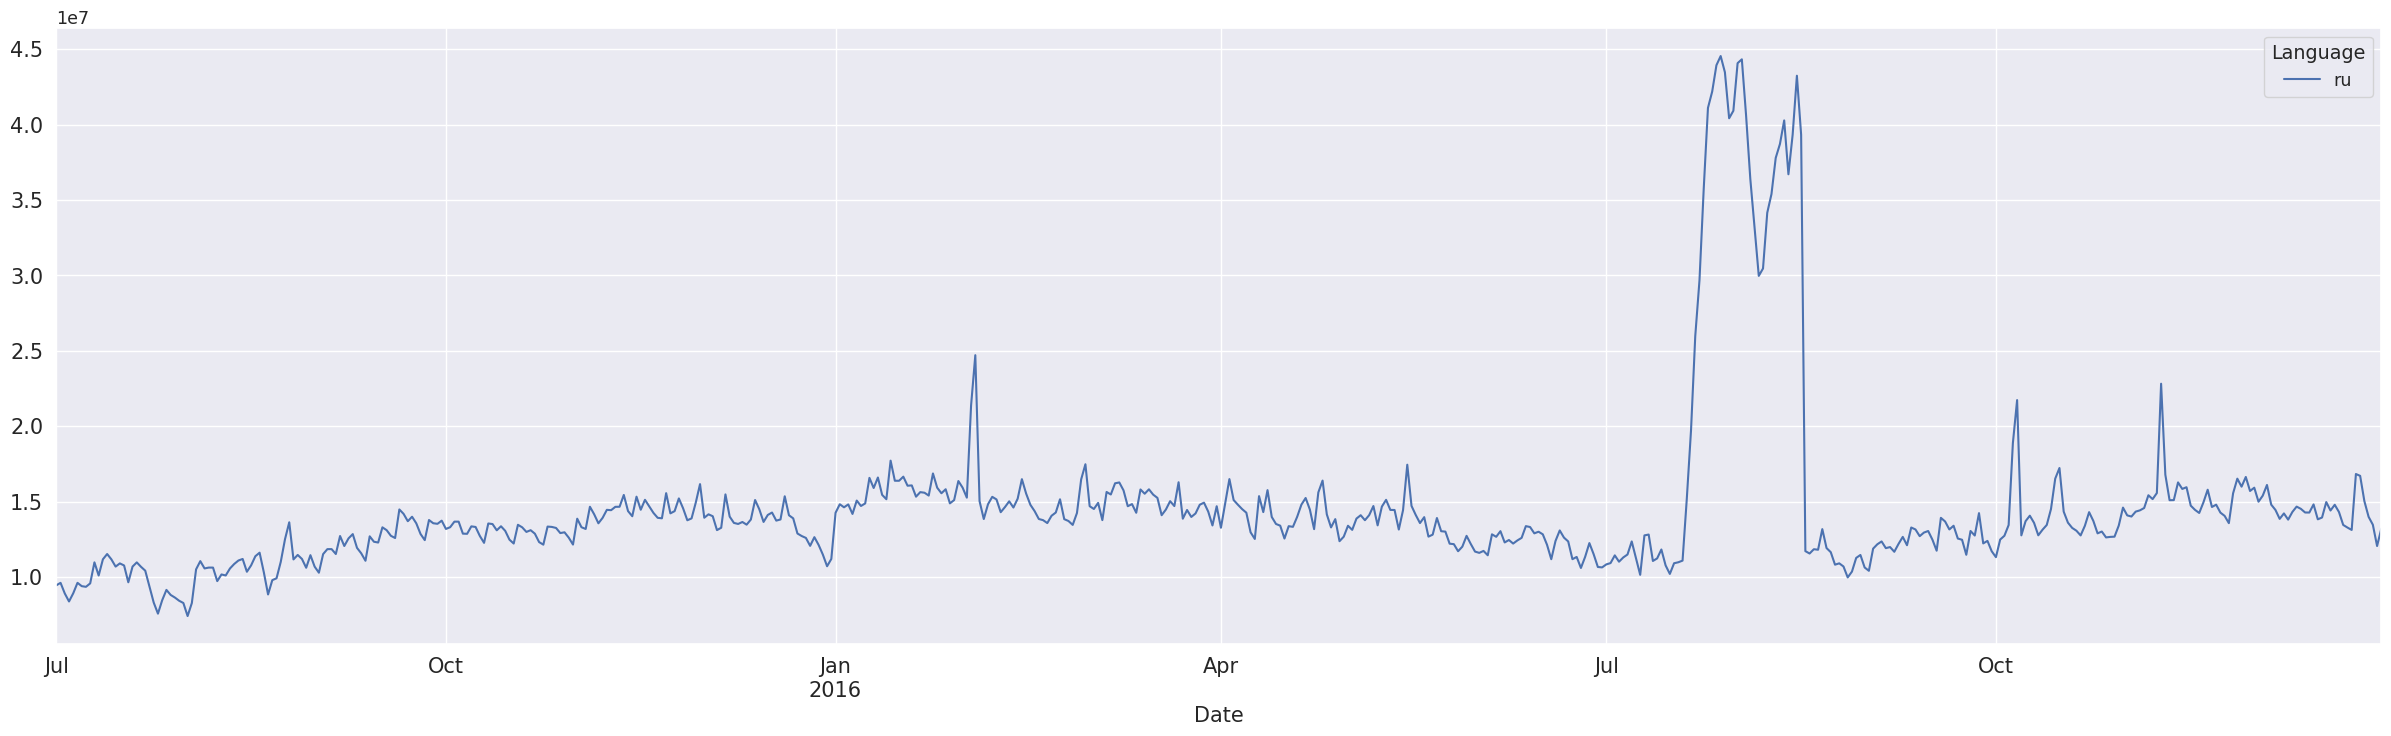

In [ ]:
#Views on Ru language Pages
df_ru=df1[['Date','ru']]
df_ru.set_index('Date', inplace=True)

df_ru.plot(figsize=(30,8),fontsize=15)
plt.xlabel('Date',fontsize=15)

Text(0.5, 0, 'Date')

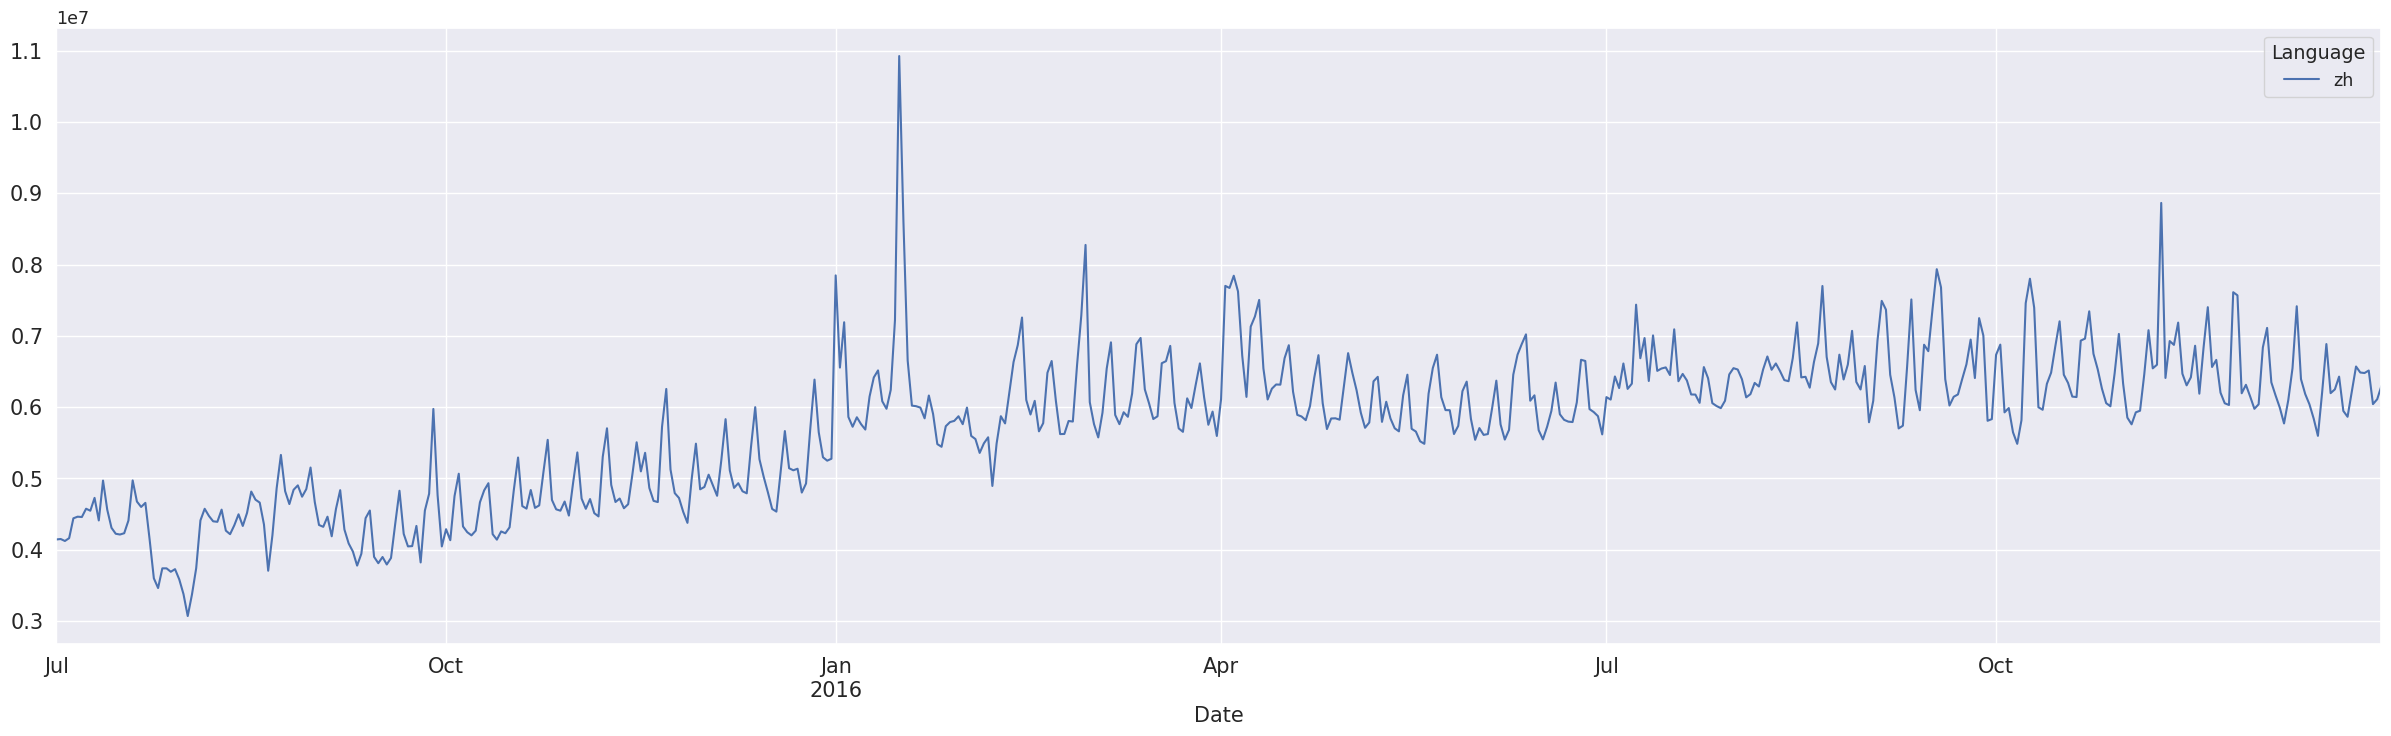

In [ ]:
#Views on Zh language Pages
df_zh=df1[['Date','zh']]
df_zh.set_index('Date', inplace=True)

df_zh.plot(figsize=(30,8),fontsize=15)
plt.xlabel('Date',fontsize=15)

Text(0.5, 0, 'Date')

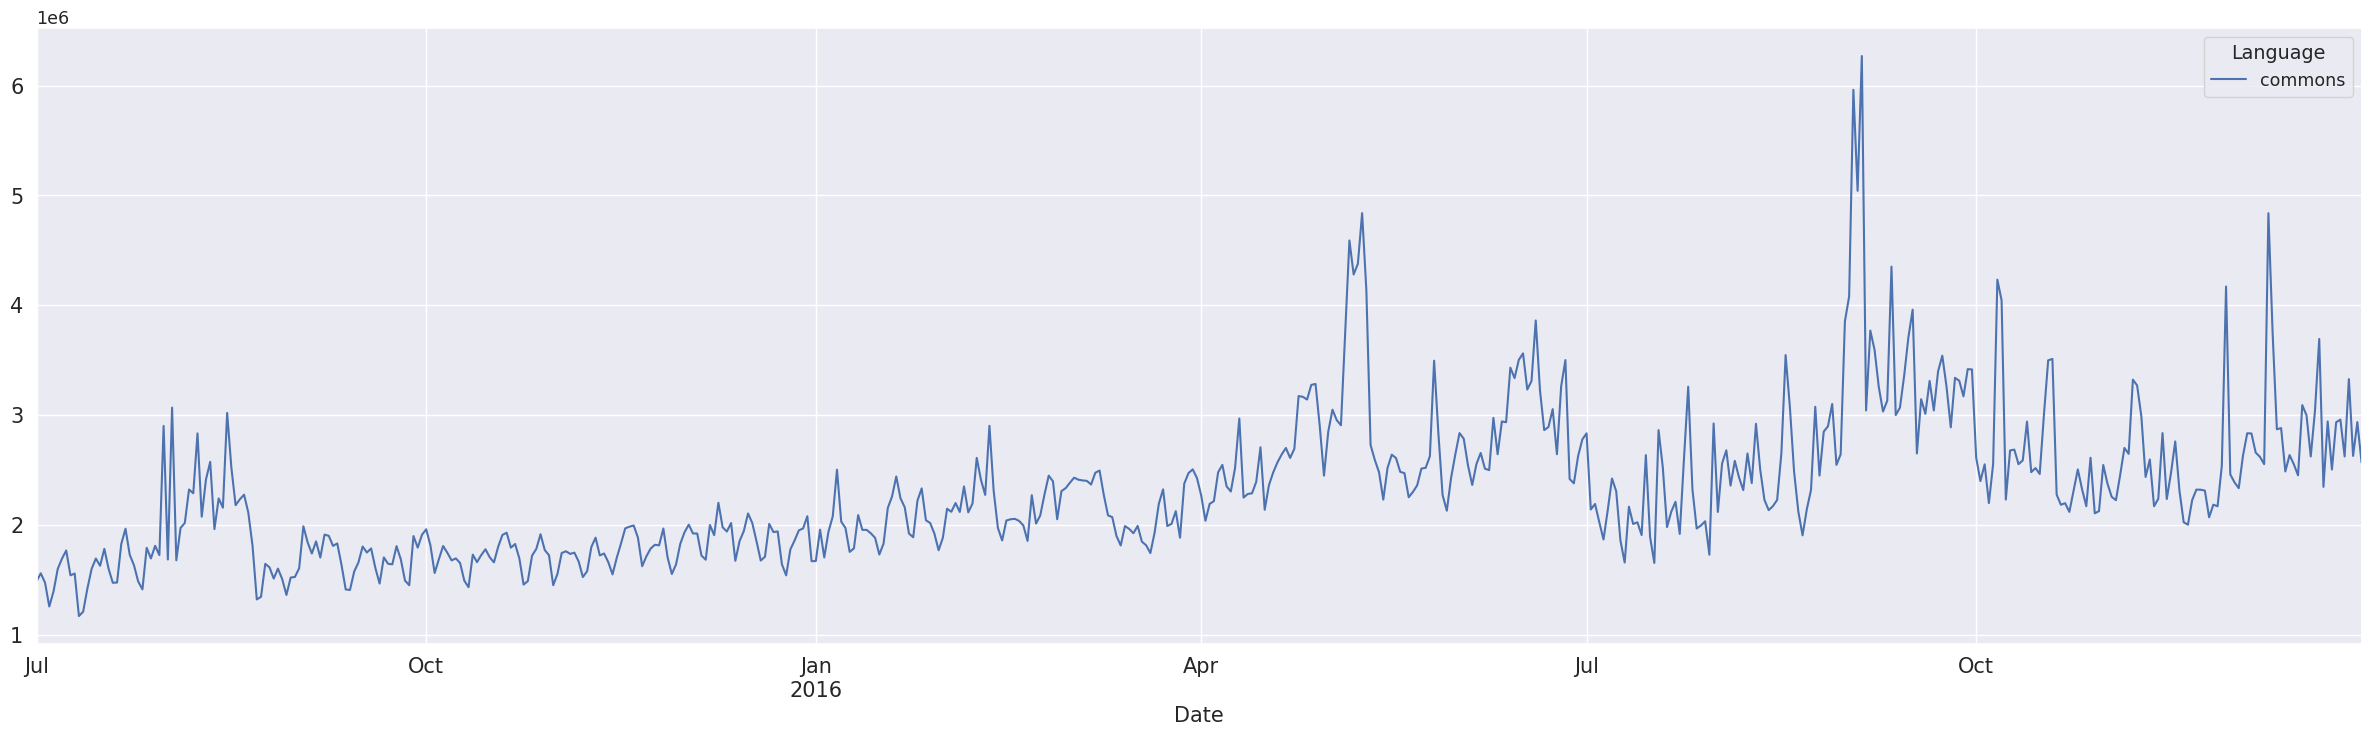

In [ ]:
#Views on Commons language Pages
df_commons=df1[['Date','commons']]
df_commons.set_index('Date', inplace=True)

df_commons.plot(figsize=(30,8),fontsize=15)
plt.xlabel('Date',fontsize=15)

# Visualizing Decomposition of Series across Various Languages

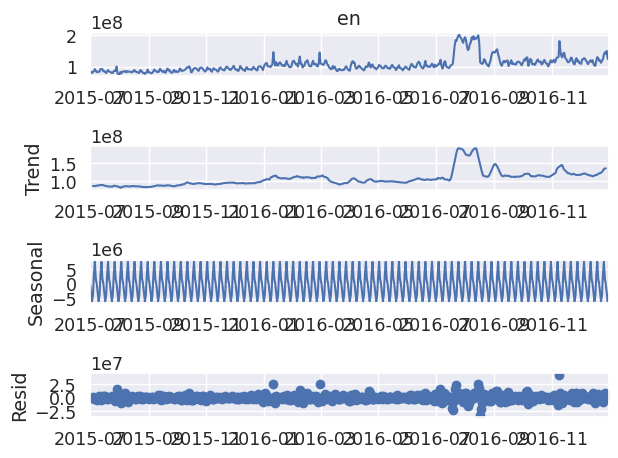

In [ ]:
import statsmodels.api as sm

model_en = sm.tsa.seasonal_decompose(df_en.en, model='additive')
model_en.plot();

<Axes: xlabel='Date'>

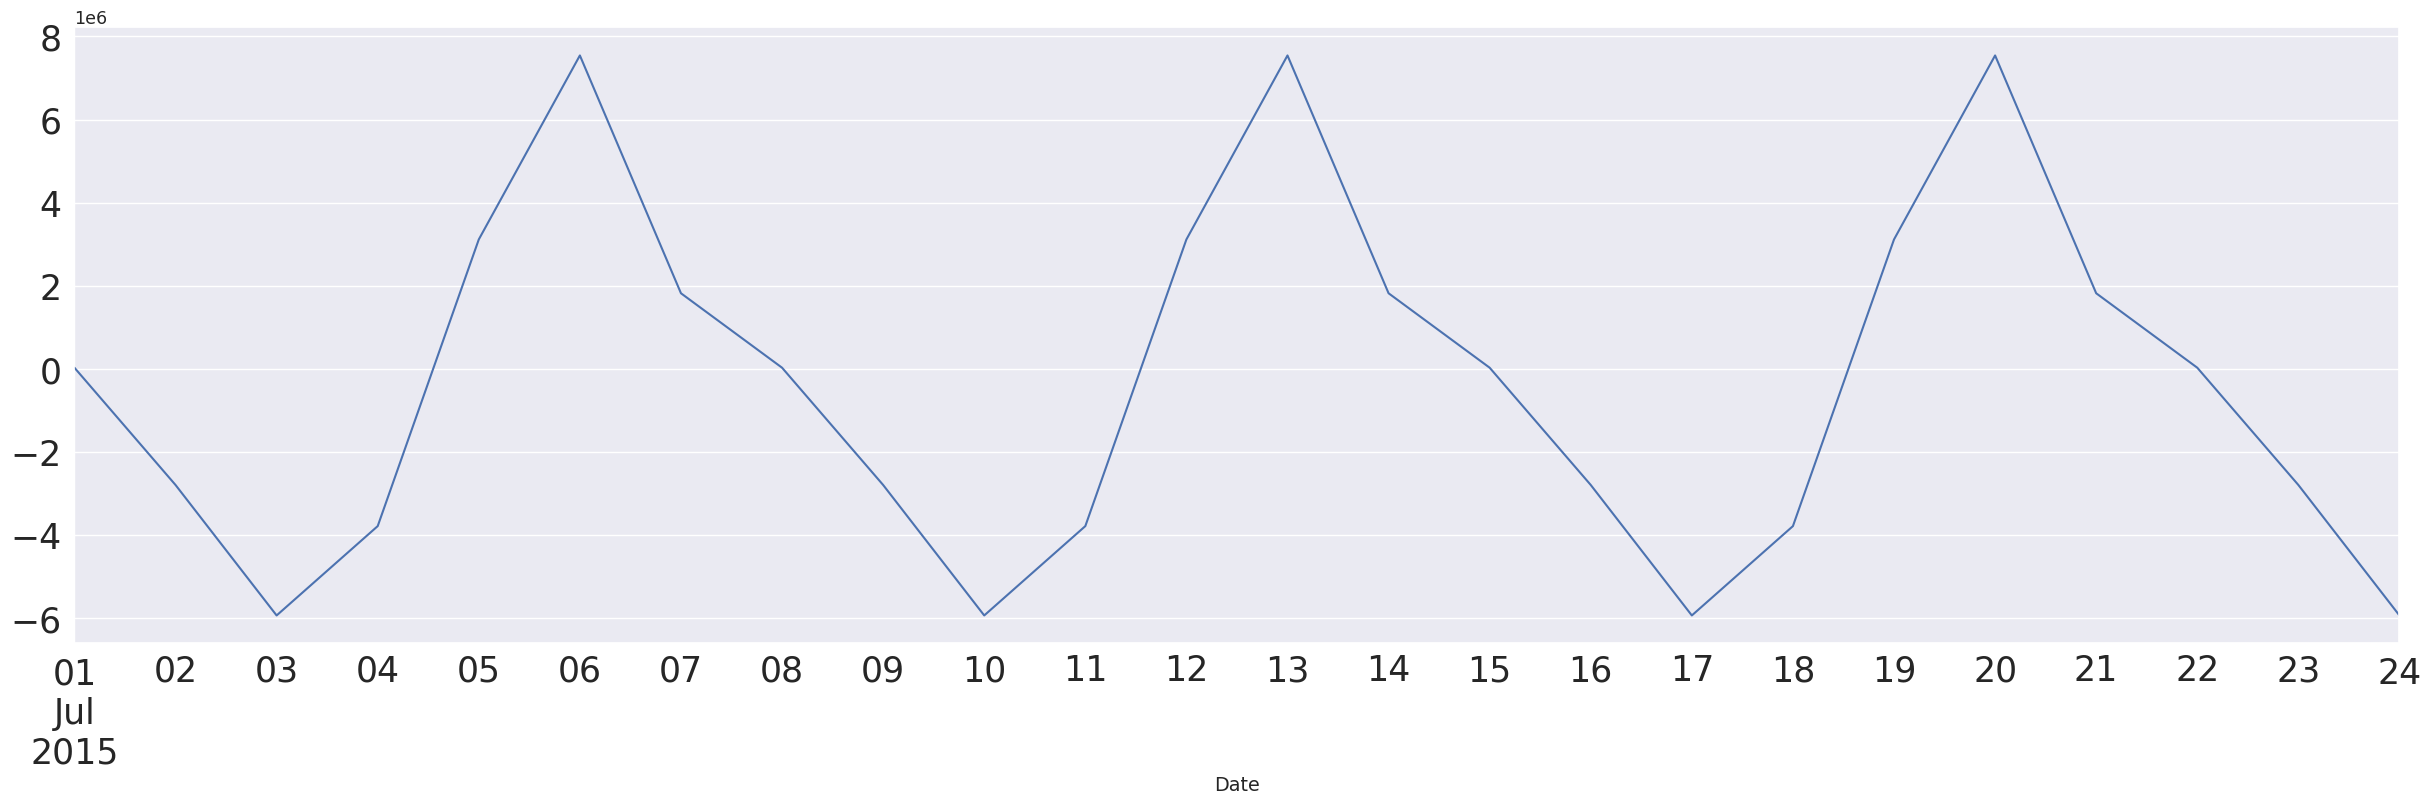

In [ ]:
model_en.seasonal[:24].plot(figsize=(30,8),fontsize=25)

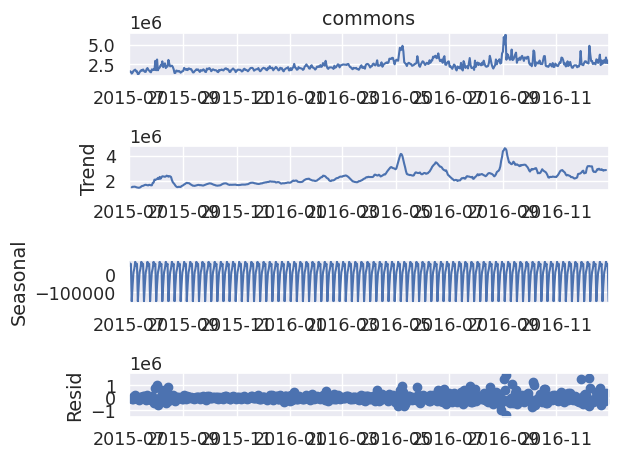

In [ ]:
model_commons = sm.tsa.seasonal_decompose(df_commons.commons, model='additive')
model_commons.plot();

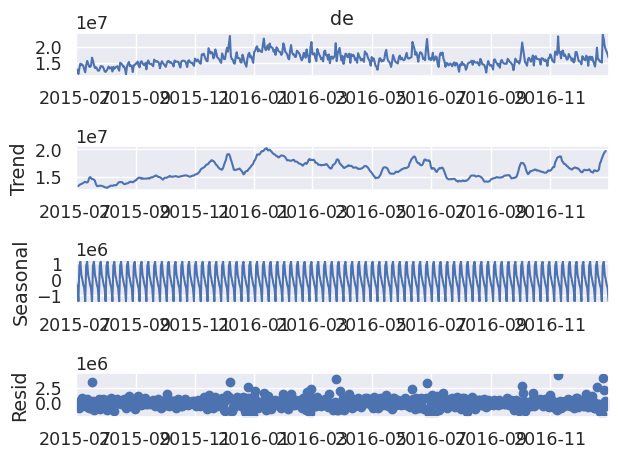

In [ ]:
model_de = sm.tsa.seasonal_decompose(df_de.de, model='additive')
model_de.plot();

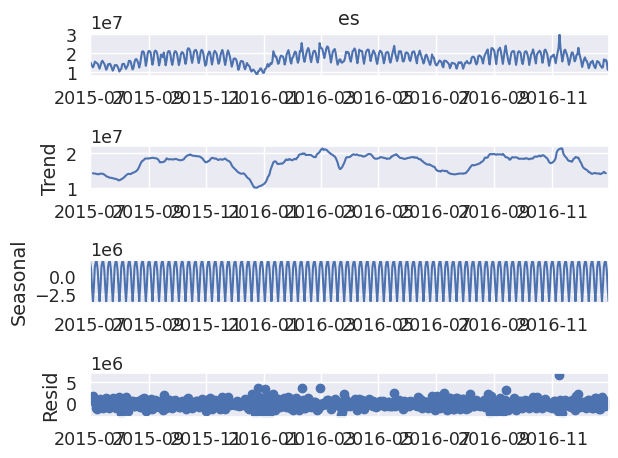

In [ ]:
model_es = sm.tsa.seasonal_decompose(df_es.es, model='additive')
model_es.plot();

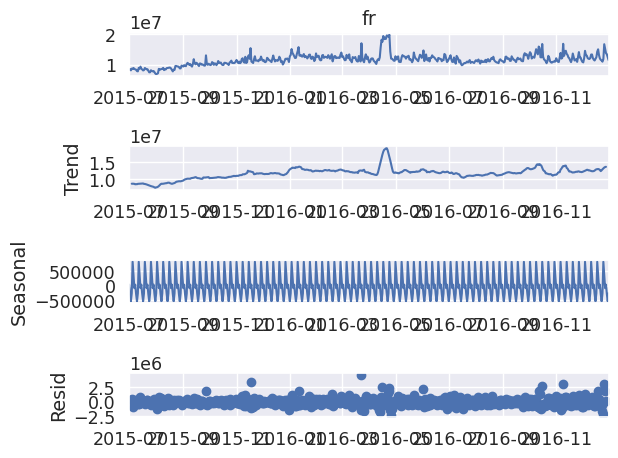

In [ ]:
model_fr = sm.tsa.seasonal_decompose(df_fr.fr, model='additive')
model_fr.plot();

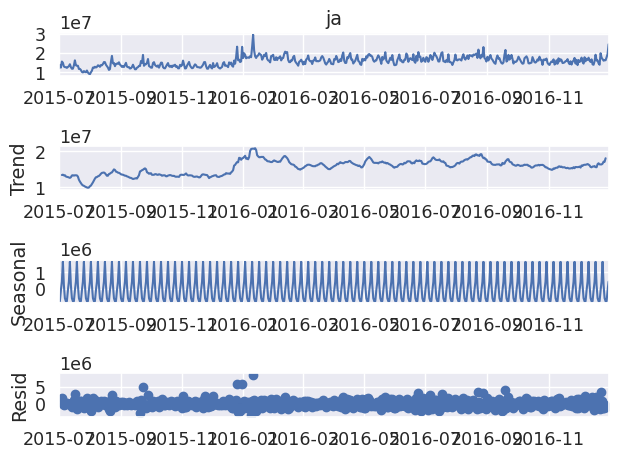

In [ ]:
model_ja = sm.tsa.seasonal_decompose(df_ja.ja, model='additive')
model_ja.plot();

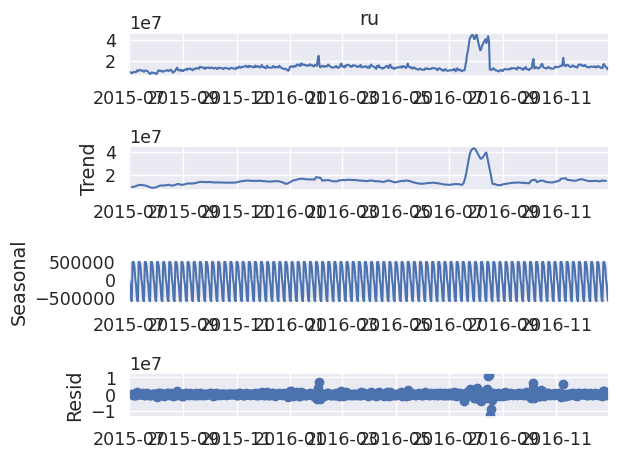

In [ ]:
model_ru = sm.tsa.seasonal_decompose(df_ru.ru, model='additive')
model_ru.plot();

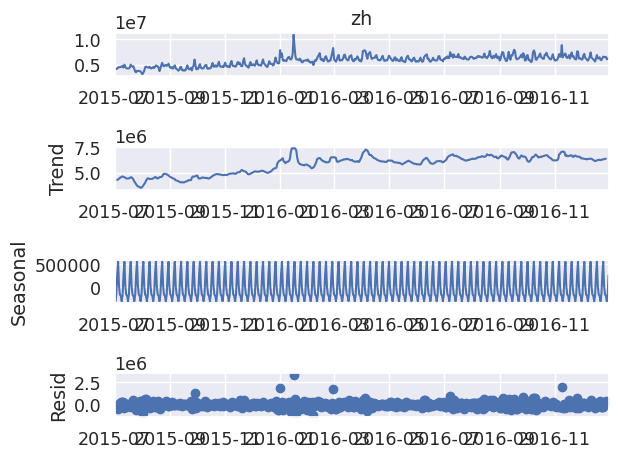

In [ ]:
model_zh = sm.tsa.seasonal_decompose(df_zh.zh, model='additive')
model_zh.plot();

**Observations**

* Seasonality for English Language pages is 7 days.
* Residuals after Decomposing are seems to Be Stationary by Visualization(can confirm using Dicky Fuller Test).
* By seeing Trends we can tell that there is some Similarity is seen in English and Russian Language Pages. 

# Plotting ACF AND PACF Plots 

In [ ]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))

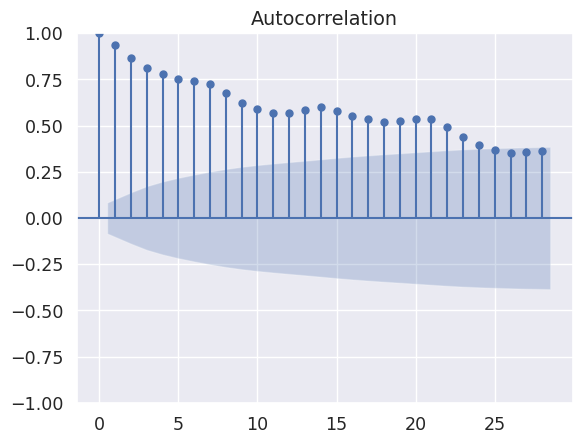

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(df_en.en);

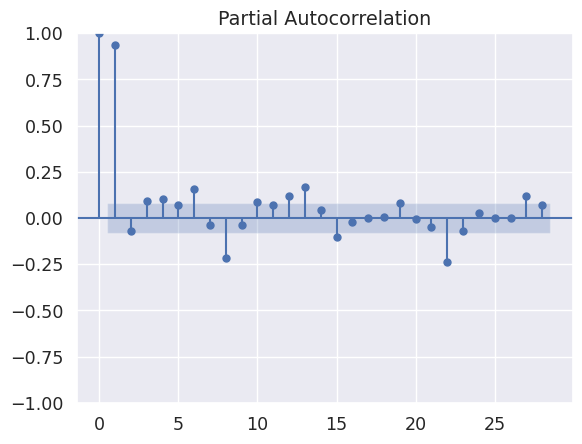

In [ ]:
plot_pacf(df_en.en);

**Splitting the Data into Train-Test split**

In [ ]:
train_x = df_en.loc[df_en.index < df_en.index[-7]].copy()
test_x = df_en.loc[df_en.index >= df_en.index[-7]].copy()

# Dicky Fuller Test

In [ ]:
sm.tsa.stattools.adfuller(df_en.en)[1]

0.18953171039920674

In [ ]:
def adf_test(data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1] 
    if pvalue <= significance_level:
        print('Sequence is stationary')
    else:
        print('Sequence is not stationary')

In [ ]:
adf_test(df_en.en)

Sequence is not stationary


**Observations:**

* Time Series is not Stationary so we will Difference the series and check again the Stationary

In [ ]:
train_x_st = train_x.copy()

train_x_st.en = train_x_st.en.diff(1)

<Axes: xlabel='Date'>

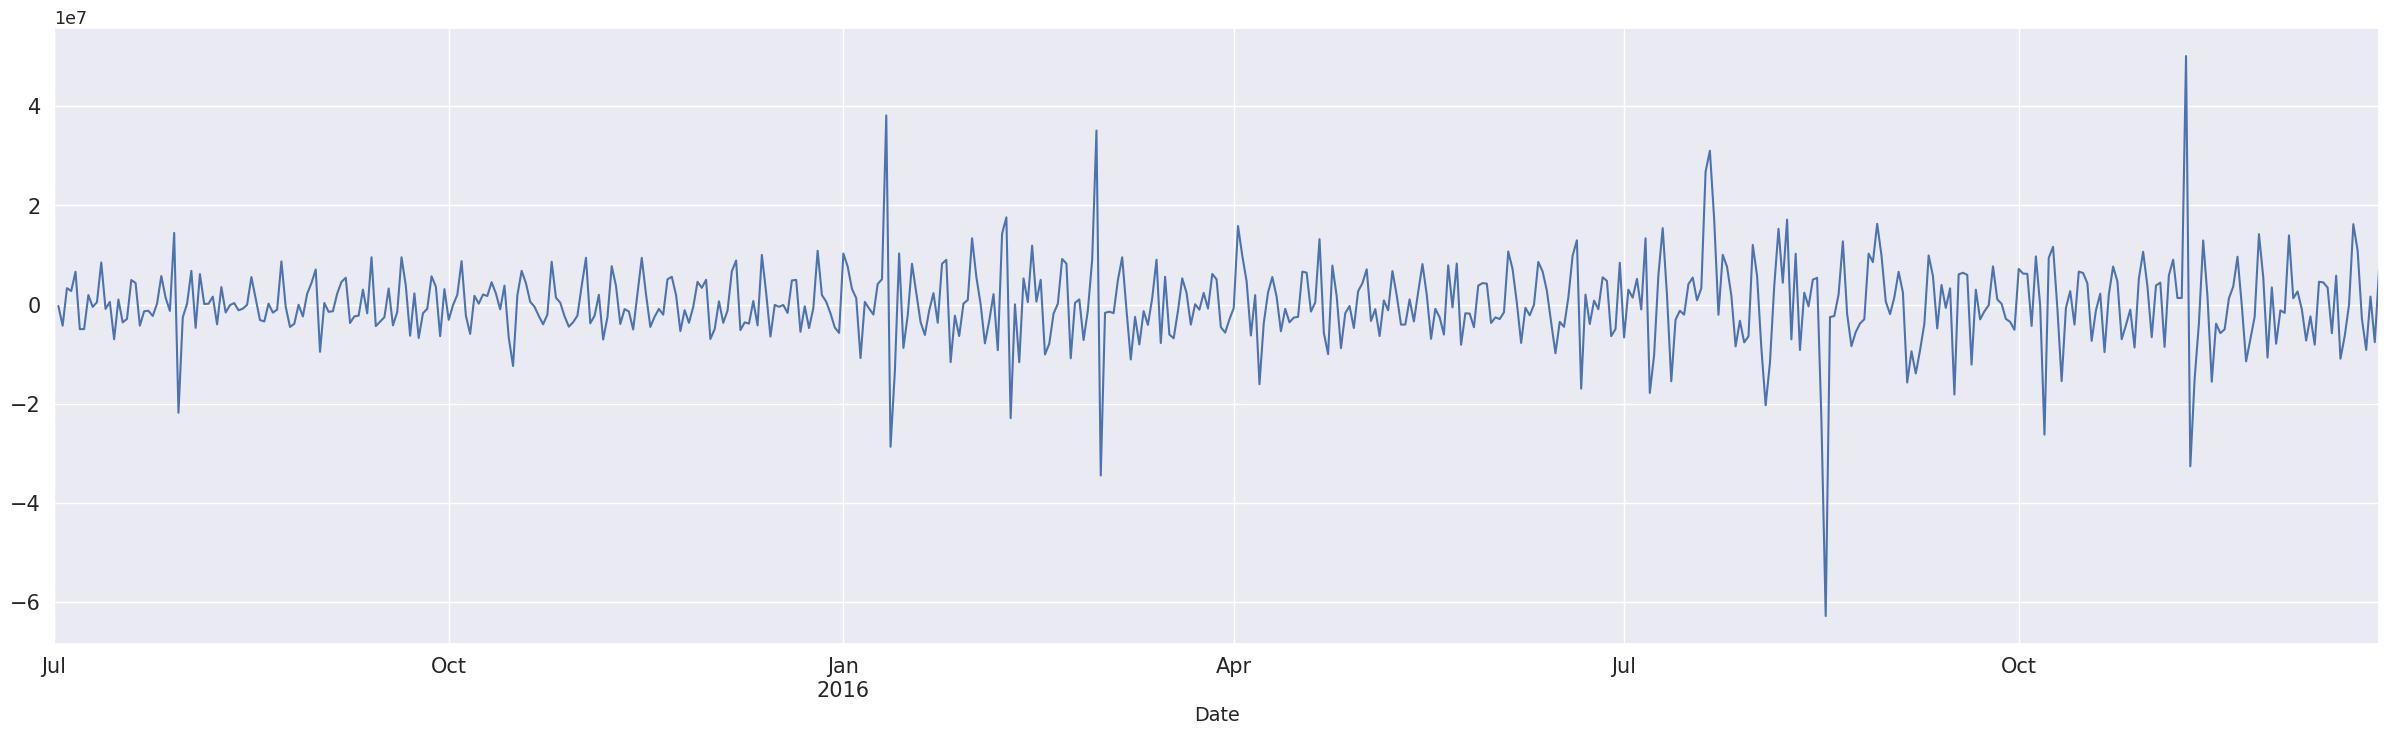

In [ ]:
train_x_st.en.plot(figsize=(30,8),fontsize=15)

In [ ]:
train_x_st.dropna(inplace=True)
adf_test(train_x_st.en)

Sequence is stationary


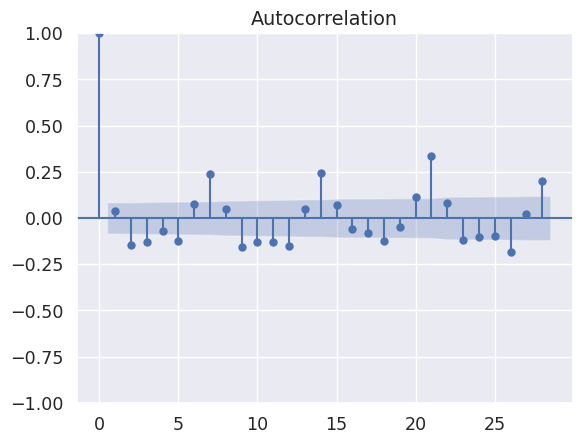

In [ ]:
#ACF Plot
plot_acf(train_x_st.en);

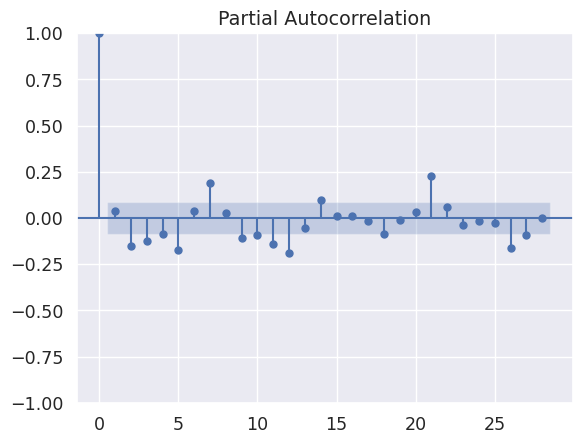

In [ ]:
#PACF Plot
plot_pacf(train_x_st.en);

# ARIMA MODEL for ENG Language


Here Parameter d is equal to 1 because we got stationary series after differencing the series for one time

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

MAE : 13583270.053
RMSE : 16912825.169
MAPE: 0.095


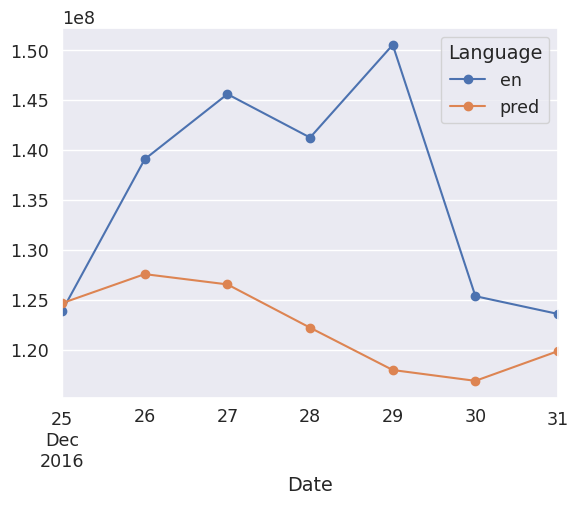

In [ ]:
model = SARIMAX(train_x.en, order=(3, 1, 3)) 
model = model.fit(disp=False)


test_x['pred'] = model.forecast(steps=7)

# Plotting
test_x.plot(style='-o')
performance(test_x['en'], test_x['pred'])

# Custom GridSearchCV for ARIMA Model

**Here After Differencing the TimeSeries one time the series is stationary
so Value of "d" is 1 for Arima Model**

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape

def evaluate_models(dataset, p_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_p,best_q = float("inf"), None, None
    for p in p_values:
        for q in q_values:
            model = SARIMAX(train_x.en, order=(p,1,q)) 
            model = model.fit(disp=False)
            test_x['pred'] = model.forecast(steps=7)
            MAPE=round(mape(test_x['en'], test_x['pred']), 3)
            if best_score>MAPE:
                best_score=MAPE
                best_p=p
                best_q=q

    print('Best MAPE:',best_score,'Best_p:',best_p,'Best_q:',best_q)

In [ ]:
p_values=[1,2,3,4,5,6]
q_values=[1,2,3,4,5]
evaluate_models(train_x.en, p_values, q_values)

Best MAPE: 0.091 Best_p: 5 Best_q: 2


**Training with Best Parameters**

MAE : 13114498.388
RMSE : 16746946.547
MAPE: 0.091


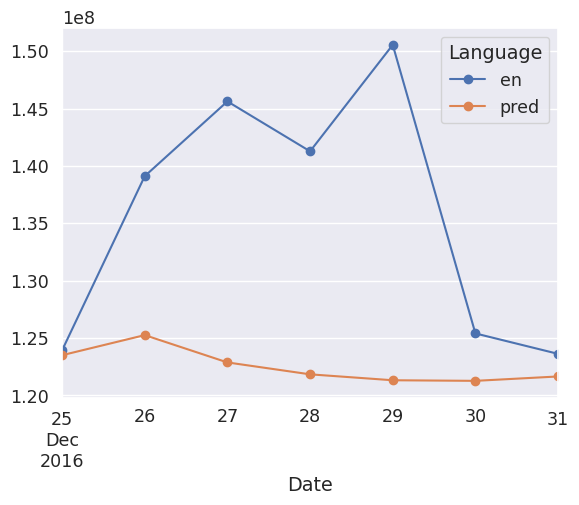

In [ ]:
model = SARIMAX(train_x.en, order=(5, 1, 2)) 
model = model.fit(disp=False)


test_x['pred'] = model.forecast(steps=7)

# Plotting
test_x.plot(style='-o')
performance(test_x['en'], test_x['pred'])

# SARIMA MODEL for ENG language

In [ ]:
Exog_Campaign_eng.shape

(550, 1)

In [ ]:
df_en=df_en.reset_index()
df_en

Language       Date           en
0        2015-07-01   84712190.0
1        2015-07-02   84438545.0
2        2015-07-03   80167728.0
3        2015-07-04   83463204.0
4        2015-07-05   86198637.0
..              ...          ...
545      2016-12-27  145628734.0
546      2016-12-28  141278366.0
547      2016-12-29  150557534.0
548      2016-12-30  125404585.0
549      2016-12-31  123623812.0

[550 rows x 2 columns]

In [ ]:
df_en1=pd.concat([df_en,Exog_Campaign_eng],axis=1)
df_en1

Date           en  Exog
0   2015-07-01   84712190.0     0
1   2015-07-02   84438545.0     0
2   2015-07-03   80167728.0     0
3   2015-07-04   83463204.0     0
4   2015-07-05   86198637.0     0
..         ...          ...   ...
545 2016-12-27  145628734.0     1
546 2016-12-28  141278366.0     1
547 2016-12-29  150557534.0     1
548 2016-12-30  125404585.0     0
549 2016-12-31  123623812.0     0

[550 rows x 3 columns]

In [ ]:
# Train-Test Split
train = df_en1.iloc[:543]
test = df_en1.iloc[543:]

In [ ]:
model = SARIMAX(train['en'],order=(5,1,2),seasonal_order=(7,1,6,7))
results = model.fit(disp=False)

predictions = results.predict(steps=7).rename('Predictions')

test = test.dropna()

predictions = predictions[-7:]

predictions.index= test.index

MAE : 17074420.503
RMSE : 18924797.286
MAPE: 0.122


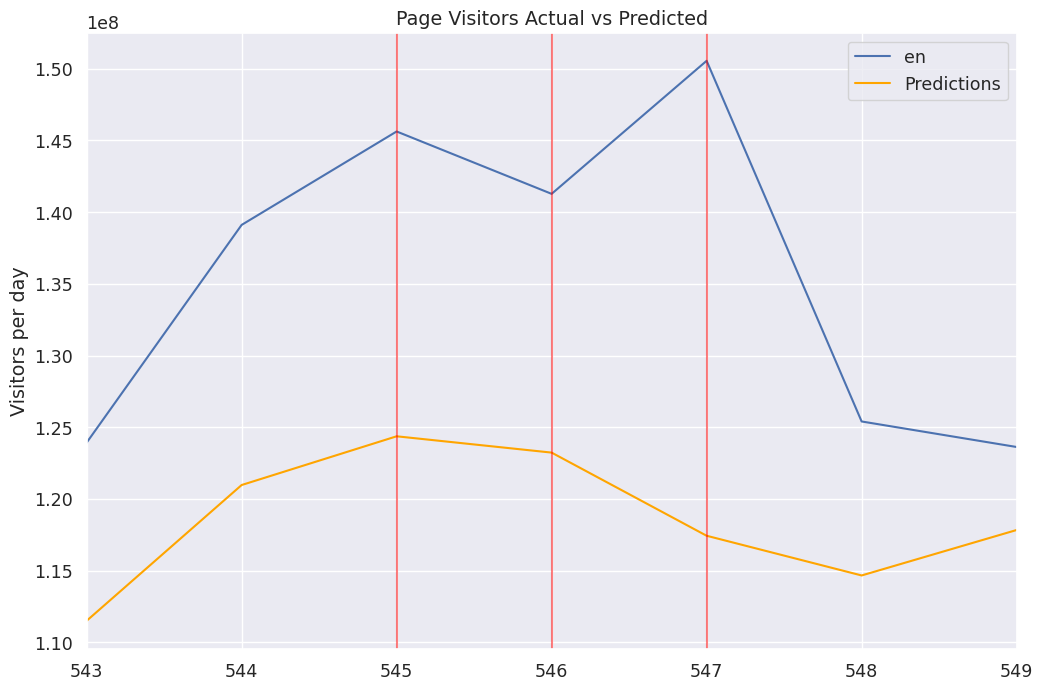

In [ ]:
performance(test['en'], predictions)
# Plot predictions against known values
title='Page Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['en'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('Exog==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5);

**Building Model with Exogoneous Variable**

In [ ]:
model = SARIMAX(train['en'], exog=train['Exog'], order=(5,1,2),seasonal_order=(7,1,6,7))
results = model.fit(disp=False)

exog_forecast = test[['Exog']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=test.index[0], end=test.index[-1], exog=exog_forecast).rename('Predictions')

MAE : 5358854.54
RMSE : 6050320.807
MAPE: 0.039


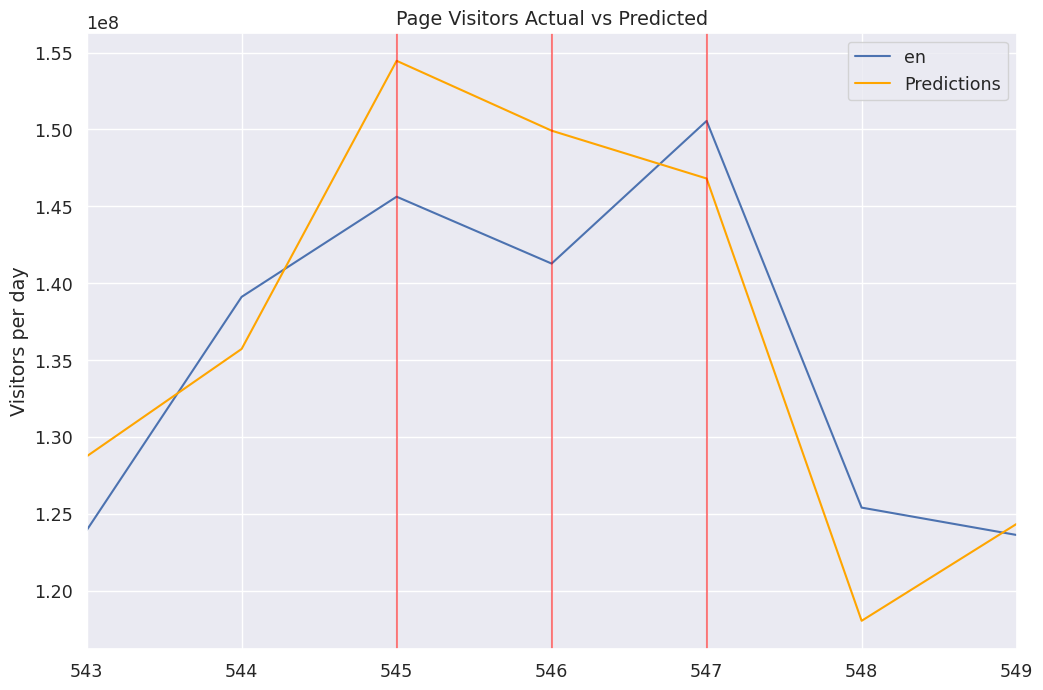

In [ ]:
performance(test['en'], predictions)
# Plot predictions against known values
title='Page Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['en'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('Exog==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5);

# Custom GridSearchCV for SARIMA Model

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape

def evaluate_models(dataset, P_values, Q_values):
    dataset = dataset.astype('float32')
    best_score, best_P,best_Q = float("inf"), None, None
    for P in P_values:
        for Q in Q_values:
            model = SARIMAX(train['en'], exog=train['Exog'], order=(5,1,2),seasonal_order=(P,1,Q,7))
            results = model.fit(disp=False)
            exog_forecast = test[['Exog']]  # requires two brackets to yield a shape of (35,1)
            predictions = results.predict(start=test.index[0], end=test.index[-1], exog=exog_forecast).rename('Predictions')
            MAPE=round(mape(test['en'], predictions), 3)
            if best_score>MAPE:
                best_score=MAPE
                best_P=P
                best_Q=Q

    print('Best MAPE:',best_score,'Best_P:',best_P,'Best_Q:',best_Q)

In [ ]:
P_values=[1,2,3,4,5,6]
Q_values=[1,2,3,4,5,6]
evaluate_models(train_x.en, P_values, Q_values)

Best MAPE: 0.036 Best_P: 1 Best_Q: 5


**Training with Best Parameters**

In [ ]:
model = SARIMAX(train['en'], exog=train['Exog'], order=(5,1,2),seasonal_order=(1,1,5,7))
results = model.fit(disp=False)

exog_forecast = test[['Exog']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=test.index[0], end=test.index[-1], exog=exog_forecast).rename('Predictions')

MAE : 4940293.307
RMSE : 5326884.431
MAPE: 0.036


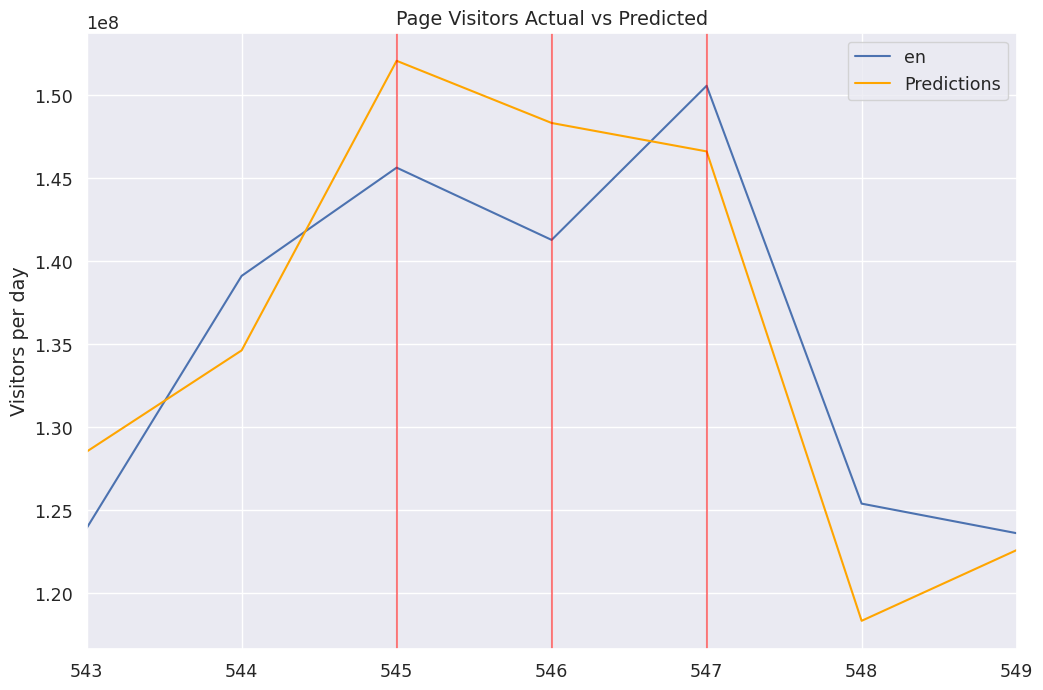

In [ ]:
performance(test['en'], predictions)
# Plot predictions against known values
title='Page Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['en'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('Exog==1').index: 
    ax.axvline(x=x, color='red', alpha = 0.5);

# Facebook prophet for Eng Language

In [ ]:
df_en.columns

Index(['Date', 'en'], dtype='object', name='Language')

In [ ]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    550 non-null    datetime64[ns]
 1   en      550 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.7 KB


In [ ]:
df_eng=df_en.copy()
df_eng.rename(columns={'Date':'ds','en':'y'},inplace=True)
df_eng

Language         ds            y
0        2015-07-01   84712190.0
1        2015-07-02   84438545.0
2        2015-07-03   80167728.0
3        2015-07-04   83463204.0
4        2015-07-05   86198637.0
..              ...          ...
545      2016-12-27  145628734.0
546      2016-12-28  141278366.0
547      2016-12-29  150557534.0
548      2016-12-30  125404585.0
549      2016-12-31  123623812.0

[550 rows x 2 columns]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


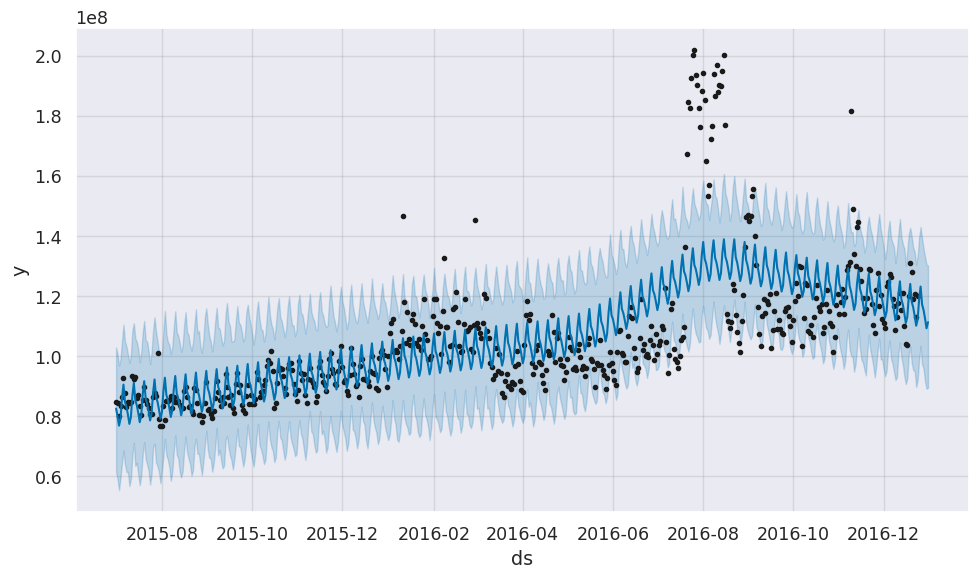

In [ ]:
from fbprophet import Prophet
m=Prophet()
m.fit(df_eng[['ds','y']][:-7])  #here we are leaving last 7 observations because we will predict it in'future'
future = m.make_future_dataframe(periods=7,freq="D")
forecast = m.predict(future)
fig=m.plot(forecast)

In [ ]:
df_eng1=df_en1.copy()
df_eng1.rename(columns={'Date':'ds','en':'y'},inplace=True)
df_eng1

ds            y  Exog
0   2015-07-01   84712190.0     0
1   2015-07-02   84438545.0     0
2   2015-07-03   80167728.0     0
3   2015-07-04   83463204.0     0
4   2015-07-05   86198637.0     0
..         ...          ...   ...
545 2016-12-27  145628734.0     1
546 2016-12-28  141278366.0     1
547 2016-12-29  150557534.0     1
548 2016-12-30  125404585.0     0
549 2016-12-31  123623812.0     0

[550 rows x 3 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


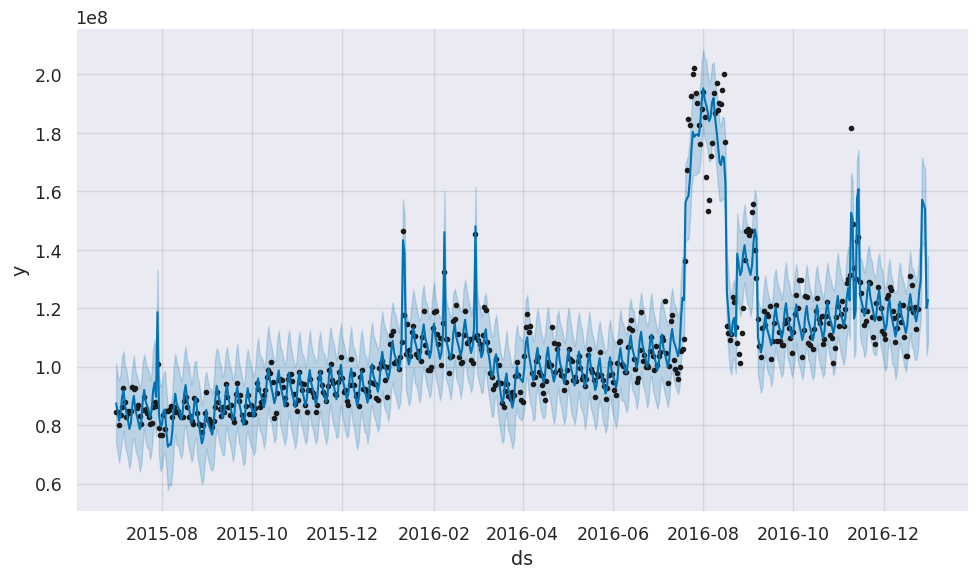

In [ ]:
model2=Prophet(interval_width=0.95,
yearly_seasonality=True,
weekly_seasonality=True,changepoint_prior_scale=4)
model2.add_regressor('Exog') #adding holidays data in the model3
model2.fit(df_eng1[:-7])
forecast2 = model2.predict(df_eng1)
fig = model2.plot(forecast2)

In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model2, initial='365.25 days', period='180 days', horizon = '7 days')

In [ ]:
df_cv.head()

ds          yhat    yhat_lower    yhat_upper            y     cutoff
0 2016-12-18  1.154342e+08  1.022559e+08  1.286702e+08  120028790.0 2016-12-17
1 2016-12-19  1.178604e+08  1.048275e+08  1.318961e+08  130939883.0 2016-12-17
2 2016-12-20  1.126470e+08  1.000444e+08  1.254652e+08  128043832.0 2016-12-17
3 2016-12-21  1.098192e+08  9.537709e+07  1.239968e+08  118888048.0 2016-12-17
4 2016-12-22  1.067070e+08  9.288131e+07  1.209290e+08  120491575.0 2016-12-17

In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse          rmse           mae      mape     mdape  \
0  1 days  2.110998e+13  4.594560e+06  4.594560e+06  0.038279  0.038279   
1  2 days  1.710736e+14  1.307951e+07  1.307951e+07  0.099889  0.099889   
2  3 days  2.370631e+14  1.539685e+07  1.539685e+07  0.120247  0.120247   
3  4 days  8.224485e+13  9.068895e+06  9.068895e+06  0.076281  0.076281   
4  5 days  1.900142e+14  1.378456e+07  1.378456e+07  0.114403  0.114403   

      smape  coverage  
0  0.039026       1.0  
1  0.105141       1.0  
2  0.127939       0.0  
3  0.079306       1.0  
4  0.121344       1.0

(0.0, 100.0)

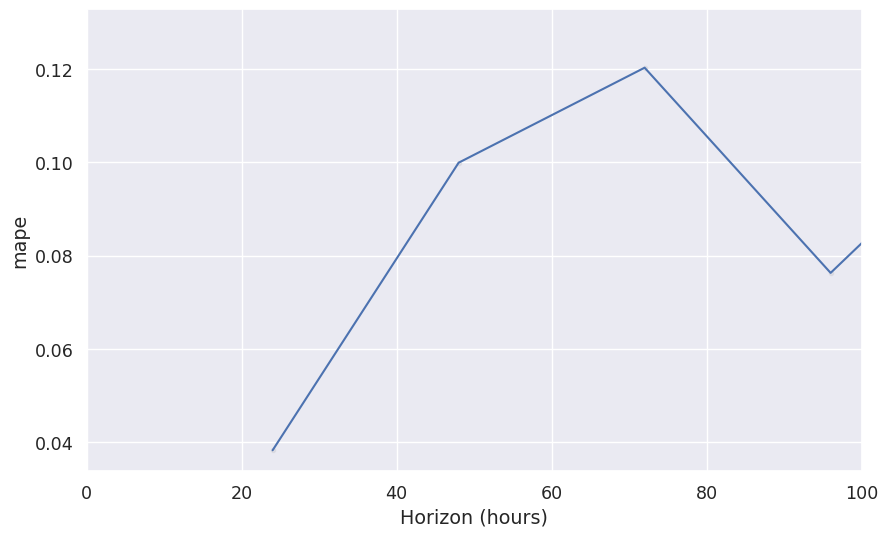

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.xlim([0, 100])

# Creating Pipeine for RU language

**WE can Use Exog Variable Beacause Eng and Ru are correlated**

In [ ]:
def evaluate_correlated_languages(languages):
  for lang in languages:
    print('Model Evaluation for ', lang,' Language')

    #Visualizing Time Series
    df_lan=df1[['Date',lang]]
    df_lan.set_index('Date', inplace=True)
    df_lan.plot(figsize=(30,8),fontsize=15)
    plt.xlabel('Date',fontsize=15)

    #Visualizing Decomposition of TimeSeries
    model_lan=sm.tsa.seasonal_decompose(df_lan[lang], model='additive')
    model_lan.plot();

    #Train-Test split for ARIMA Model Evaluation
    train_x = df_lan.loc[df_lan.index < df_lan.index[-7]].copy()
    test_x = df_lan.loc[df_lan.index >= df_lan.index[-7]].copy()

    #ARIMA MODEL
    model = SARIMAX(train_x[lang], order=(5,1,2)) 
    model = model.fit(disp=False)
    test_x['pred'] = model.forecast(steps=7)

    # Plotting ARIMA MODEL PREDICTION
    test_x.plot(style='-o')
    print('Performance for ARIMA Model')
    performance(test_x[lang], test_x['pred'])

    #Train-Test split for SARIMAX Model Evaluation
    df_lan=df_lan.reset_index()
    df_lan1=pd.concat([df_lan,Exog_Campaign_eng],axis=1)
    train = df_lan1.iloc[:543]
    test = df_lan1.iloc[543:]

    #SARIMAX MODEL
    model = SARIMAX(train[lang], exog=train['Exog'], order=(5,1,2),seasonal_order=(1,1,5,7))
    results = model.fit(disp=False)
    exog_forecast = test[['Exog']]  # requires two brackets to yield a shape of (35,1)
    predictions = results.predict(start=test.index[0], end=test.index[-1], exog=exog_forecast).rename('Predictions')

    # Plotting SARIMAX MODEL PREDICTION
    print('Performance for SARIMAX Model')
    performance(test[lang], predictions)


Model Evaluation for  ru  Language
Performance for ARIMA Model
MAE : 1760506.101
RMSE : 2262252.498
MAPE: 0.113
Performance for SARIMAX Model
MAE : 2431768.908
RMSE : 2741230.616
MAPE: 0.166


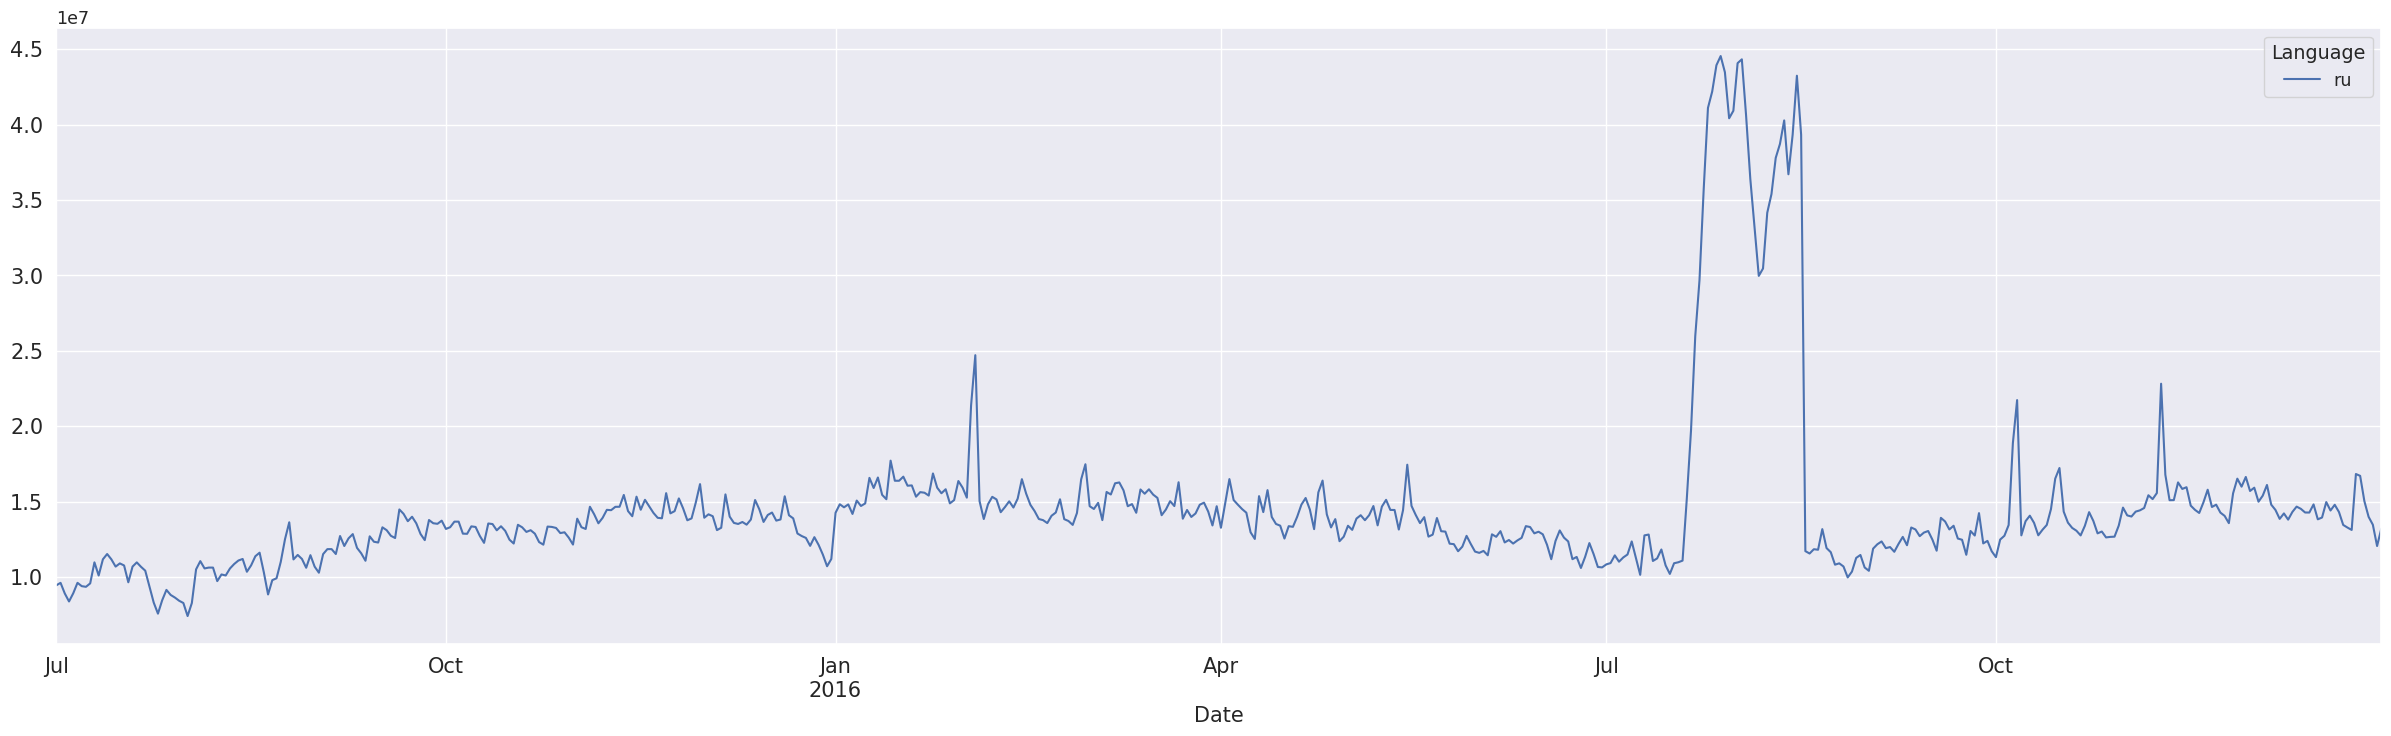

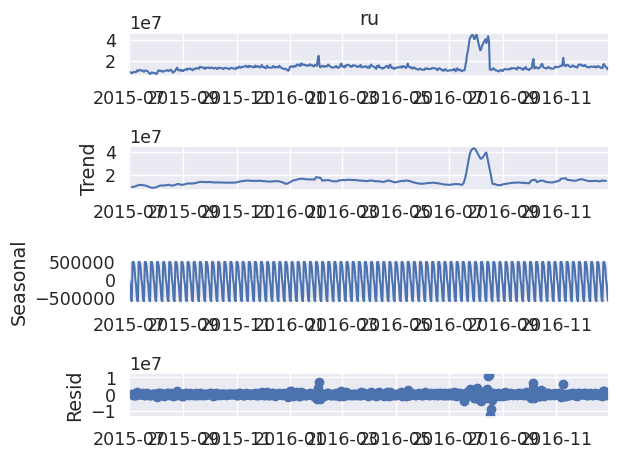

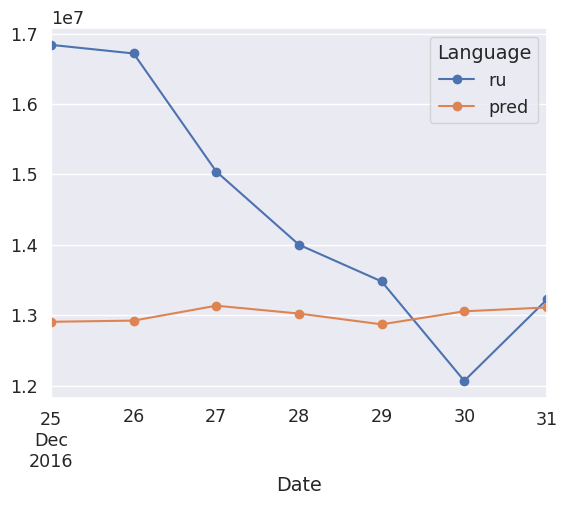

In [ ]:
languages=['ru']
evaluate_correlated_languages(languages)

# Creating a Pipeline For Other Languages

**NO need of SARIMAX Beacause we don't have Exog Variable for these Languages**

In [ ]:
#Other Languages than en and ru 
languages=['commons', 'de', 'es', 'fr', 'ja', 'zh']

def evaluate_other_languages(languages):
  for lang in languages:
    print('Model Evaluation for ', lang,' Language')

    #Visualizing Time Series
    df_lan=df1[['Date',lang]]
    df_lan.set_index('Date', inplace=True)
    df_lan.plot(figsize=(30,8),fontsize=15)
    plt.xlabel('Date',fontsize=15)

    #Visualizing Decomposition of TimeSeries
    model_lan=sm.tsa.seasonal_decompose(df_lan[lang], model='additive')
    model_lan.plot();

    #Train-Test split for ARIMA Model Evaluation
    train_x = df_lan.loc[df_lan.index < df_lan.index[-7]].copy()
    test_x = df_lan.loc[df_lan.index >= df_lan.index[-7]].copy()

    #ARIMA MODEL
    model = SARIMAX(train_x[lang], order=(5,1,2)) 
    model = model.fit(disp=False)
    test_x['pred'] = model.forecast(steps=7)

    # Plotting
    test_x.plot(style='-o')
    performance(test_x[lang], test_x['pred'])


# Questionnaire:

**1.Defining the problem statements and where can this and modifications of this be used**

Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

**2.Write 3 inferences you made from the data visualizations**

* Seasonality for English Language pages is 7 days.
* Residuals after Decomposing are seems to Be Stationary by Visualization(can confirm using Dicky Fuller Test).
* By seeing Trends we can tell that there is some Similarity is seen in English and Russian Language Pages. 

**3.What does the decomposition of series do?**

The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns

**4.What level of differencing gave you a stationary series?**

ANS: 1

**5.Difference between arima, sarima & sarimax**

ARIMA and SARIMA are both algorithms for forecasting. ARIMA takes into account the past values (autoregressive, moving average) and predicts future values based on that. SARIMA similarly uses past values but also takes into account any seasonality patterns.
In SARIMAX we take Exogenous Variable into Consideration when compared with SARIMA Model

**6.Compare the number of views in different languages**

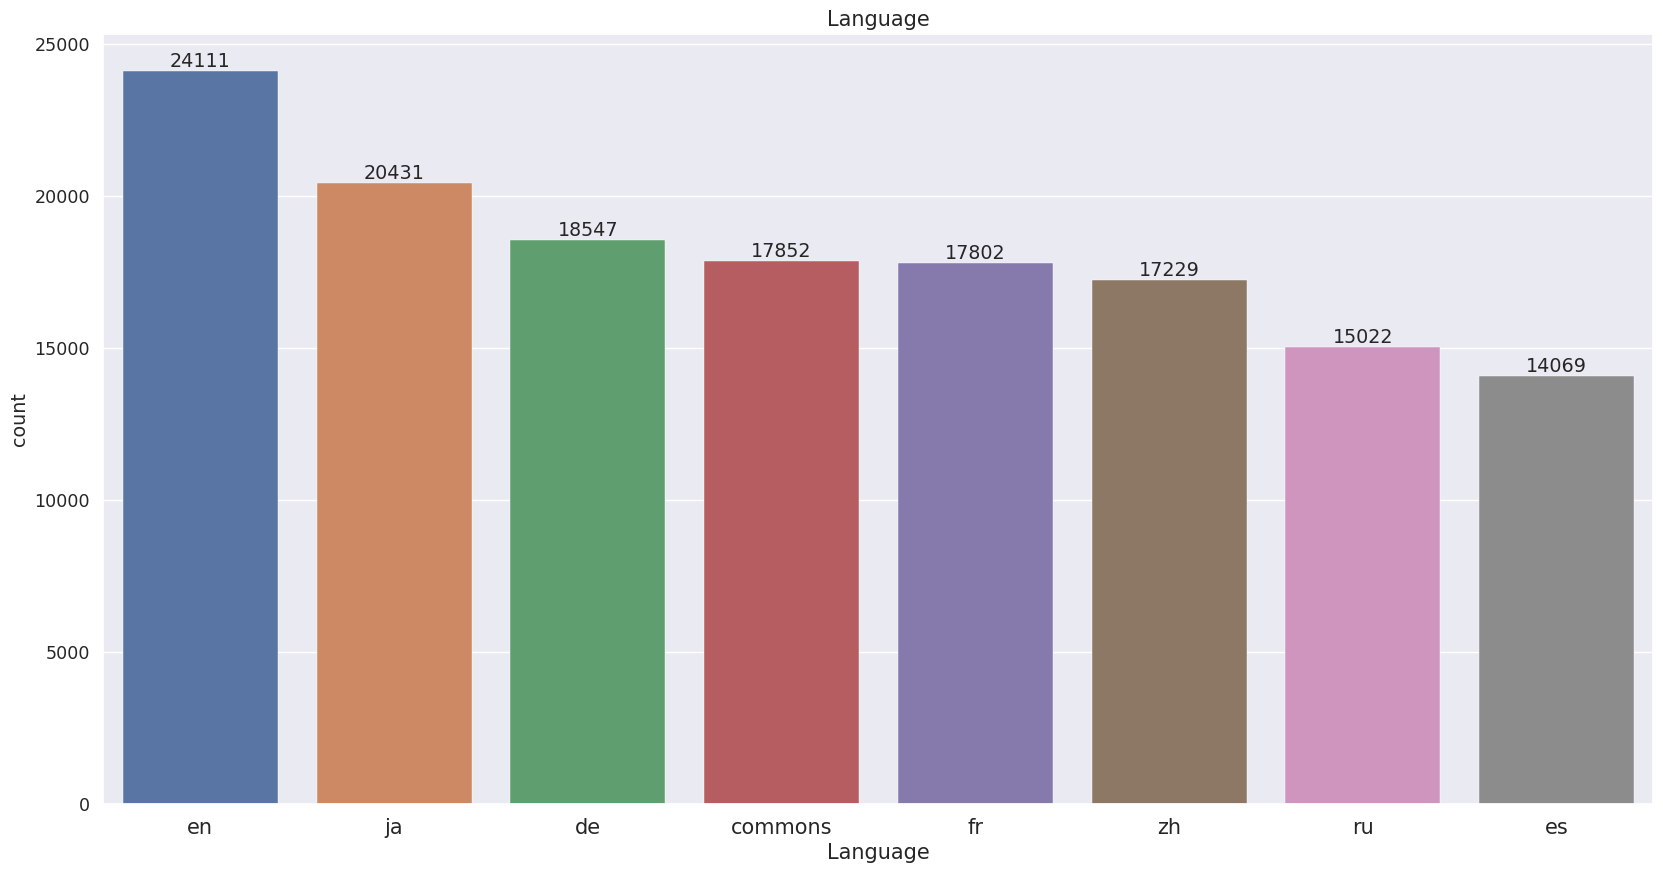

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.countplot(data = df, 
              x = 'Language', 
              order = df['Language'].value_counts().index[:], linewidth=0.3)
ax.bar_label(ax.containers[0])
plt.xticks(fontsize=15)
plt.title('Language',fontsize=15)
plt.xlabel('Language',fontsize=15)
plt.show()

**7.What other methods other than grid search would be suitable to get the model for all languages**

Diagnostic plots of the time series can be used along with heuristic rules to determine the hyperparameters of the ARIMA model